This notebook explores the features of GW time series.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules and load data.

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import pywt

# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train = pd.read_csv('./data/training_labels.csv')
test = pd.read_csv('./data/sample_submission.csv')

def get_train_file_path(image_id):
    return "./data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "./data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

print(train.info)
print(test.info)

print(train.head())
print(test.head())


<bound method DataFrame.info of                 id  target                          file_path
0       00000e74ad       1  ./data/train/0/0/0/00000e74ad.npy
1       00001f4945       0  ./data/train/0/0/0/00001f4945.npy
2       0000661522       0  ./data/train/0/0/0/0000661522.npy
3       00007a006a       0  ./data/train/0/0/0/00007a006a.npy
4       0000a38978       1  ./data/train/0/0/0/0000a38978.npy
...            ...     ...                                ...
559995  ffff9a5645       1  ./data/train/f/f/f/ffff9a5645.npy
559996  ffffab0c27       0  ./data/train/f/f/f/ffffab0c27.npy
559997  ffffcf161a       1  ./data/train/f/f/f/ffffcf161a.npy
559998  ffffd2c403       0  ./data/train/f/f/f/ffffd2c403.npy
559999  fffff2180b       0  ./data/train/f/f/f/fffff2180b.npy

[560000 rows x 3 columns]>
<bound method DataFrame.info of                 id  target                         file_path
0       00005bced6     0.5  ./data/test/0/0/0/00005bced6.npy
1       0000806717     0.5  ./data/test/0/

# Get subset of the data for testing

In [2]:
# Let's get a subset of the data for testing
num_train=10000
X_train = np.empty((num_train,3,4096),dtype='float64')
y_train = np.empty((num_train),dtype='float64')
for i in range(num_train):
    X_train[i,:,:]=np.load(train.iloc[i][2])
    y_train[i] = train.iloc[i][1]
print(X_train.shape)
print(y_train.shape)


(10000, 3, 4096)
(10000,)


In [3]:
# Split by label to compare signal vs noise
X_train_1 = X_train[y_train==1]
print(X_train_1.shape)
X_train_0 = X_train[y_train==0]
print(X_train_0.shape)

(4959, 3, 4096)
(5041, 3, 4096)


In [29]:
#import torch
#from torch.fft import fft, rfft, ifft
#
#def whiten(signal):
#    # From here: https://www.kaggle.com/kevinmcisaac/g2net-spectral-whitening
#    hann = torch.hann_window(len(signal), periodic=True, dtype=float)
#    spec = fft(torch.from_numpy(signal).float()* hann)
#    mag = torch.sqrt(torch.real(spec*torch.conj(spec)))
#
#    return torch.real(ifft(spec/mag)).numpy() * np.sqrt(len(signal)/2)

#from torchaudio.functional import bandpass_biquad
#
#def butter_bandpass_filter(data, lowcut, highcut, fs):
#    return bandpass_biquad(data, fs, (highcut + lowcut) / 2, (highcut - lowcut) / (highcut + lowcut)
from sklearn.preprocessing import MinMaxScaler

def normalize(signal):
    thisMin = np.amin(signal)
    thisMax = np.amax(signal)
    dr=thisMax-thisMin
    signal_norm = (signal-thisMin)/dr
    return signal_norm

def normalize2(signal):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(signal)
    return scaler.transform(signal)

def normalizeZ(signal):
    m = np.mean(signal)
    s = np.std(signal)
    return (signal - m)/s

def myFilter(signal, freqs, low, high):
    foo = 1/freqs
    idx = idx = np.where((foo > 15) & (foo <= 500))
    return signal[idx]

In [ ]:
# Here we investigate operations on the signal and CWT
wavelet='gaus1'
y = X_train_1[0][0][:]
coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
print(coef.shape)
print(coef)
print(freqs.shape)
print(freqs)

print('now norm')
coef, freqs=pywt.cwt(normalize(y),np.arange(1,129),wavelet)
print(coef.shape)
print(coef)
print(freqs.shape)
print(freqs)
foo=1/freqs
print(foo)
# Filter out freqs below 15Hz and above 500Hz
idx = np.where((foo > 15) & (foo <= 500))
print(idx)
print('myFilter')
tmp = myFilter(y, freqs, 15, 500)
print(tmp.shape)
print(tmp)

In [44]:
def plotSignal(x, y_signal, y_noise, normalize):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 3)
    
    if normalize:
        sig0 = normalizeZ(y_signal[0][:])
        sig1 = normalizeZ(y_signal[1][:])
        sig2 = normalizeZ(y_signal[2][:])
        noise0 = normalizeZ(y_noise[0][:])
        noise1 = normalizeZ(y_noise[1][:])
        noise2 = normalizeZ(y_noise[2][:])
    else:
        sig0 = y_signal[0][:]
        sig1 = y_signal[1][:]
        sig2 = y_signal[2][:]
        noise0 = y_noise[0][:]
        noise1 = y_noise[1][:]
        noise2 = y_noise[2][:]
            
    ax1.plot(idx, sig0, label='Hanford')
    ax1.plot(idx, sig1, label='Livingston')
    ax1.plot(idx, sig2, label='Virgo')
    ax1.set_title('Run ' + str(i) + '-signal')

    ax2.plot(idx, noise0, label='Hanford')
    ax2.plot(idx, noise1, label='Livingston')
    ax2.plot(idx, noise2, label='Virgo')
    ax2.set_title('Run ' + str(i) + '-noise')

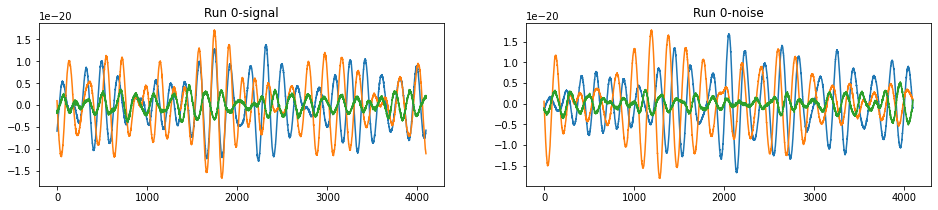

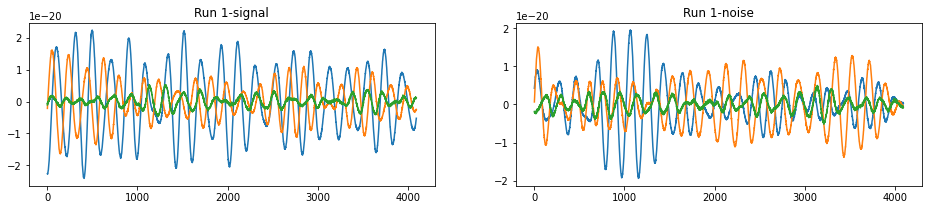

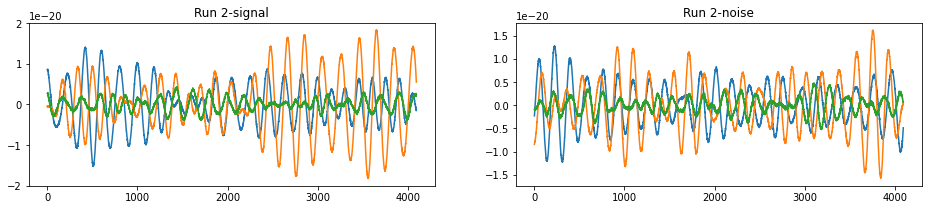

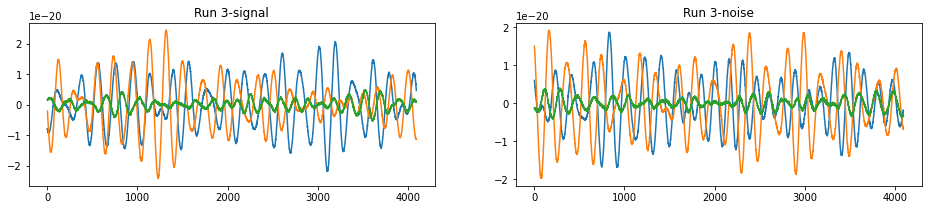

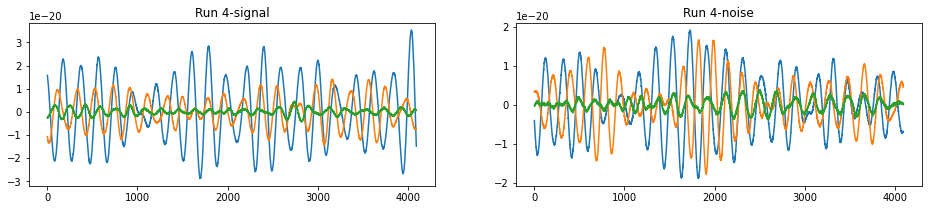

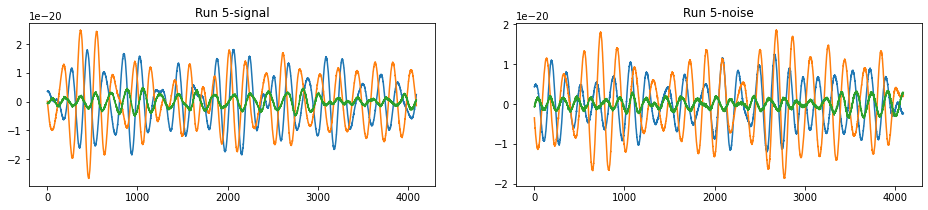

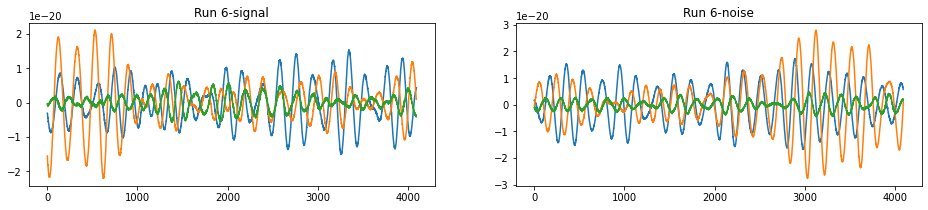

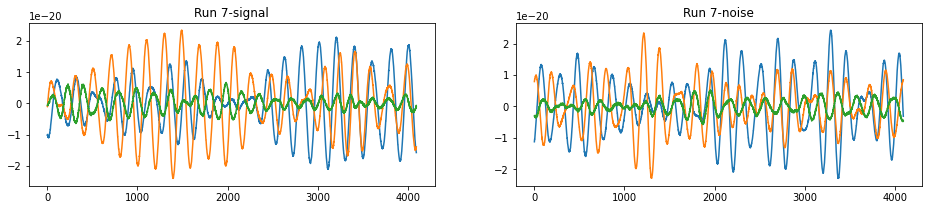

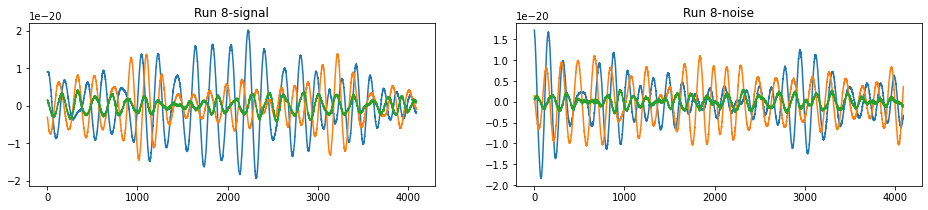

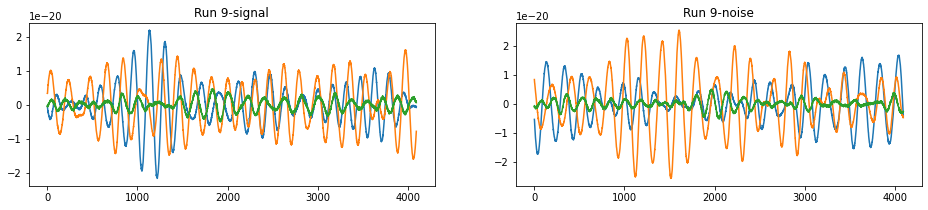

In [45]:
numComparisons = 10
idx = np.arange(0, 4096, 1)
for i in range(numComparisons):
    plotSignal(idx, X_train_1[i], X_train_0[i], False)

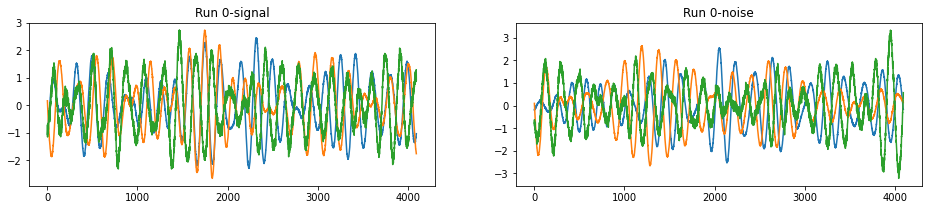

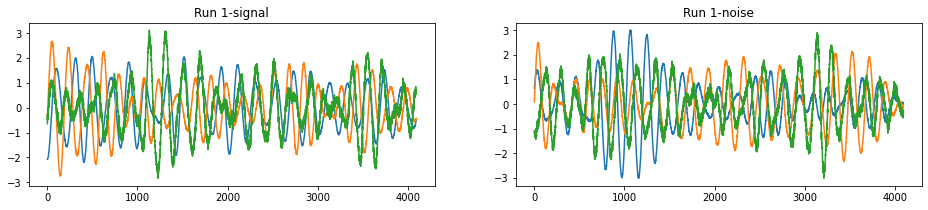

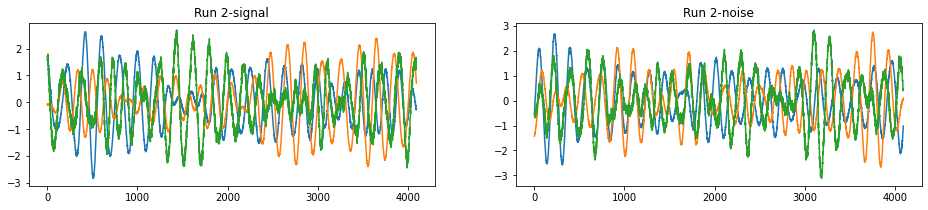

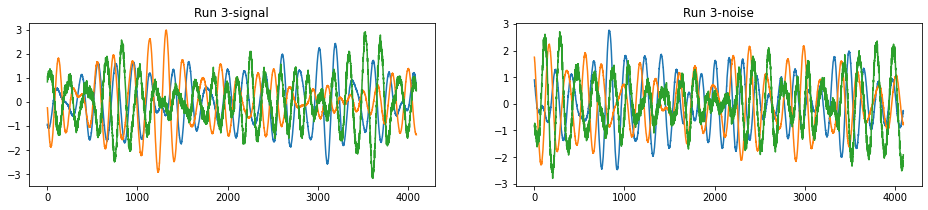

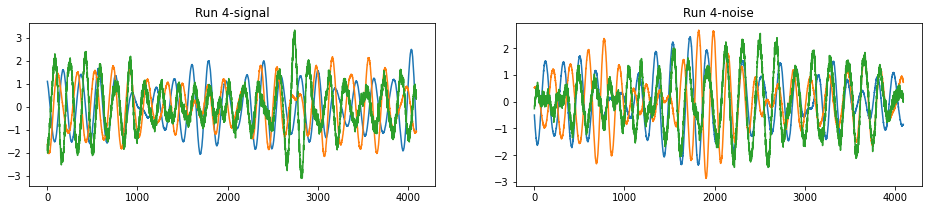

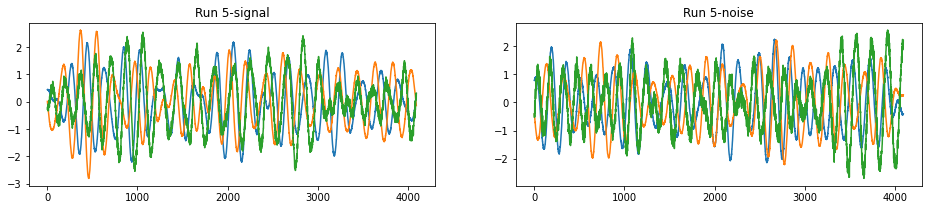

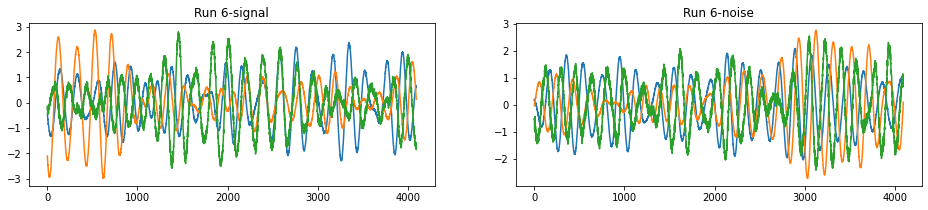

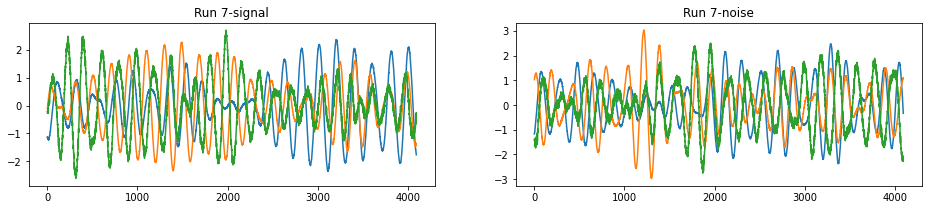

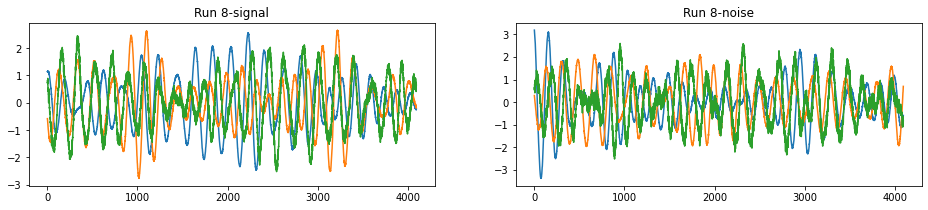

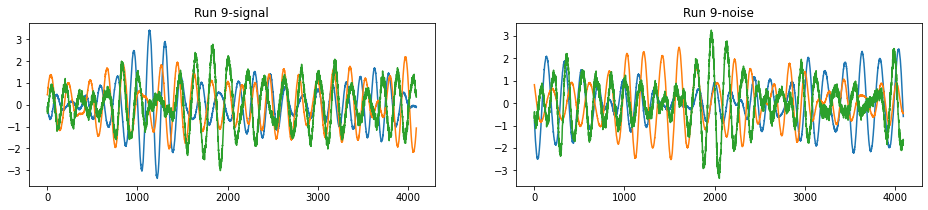

In [46]:
numComparisons = 10
idx = np.arange(0, 4096, 1)
for i in range(numComparisons):
    plotSignal(idx, X_train_1[i], X_train_0[i], True)

In [7]:
def plotCoef(X_train_1, X_train_0, i, j):
    wavelet='gaus1'

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 3)
    y = X_train_1[i][j][:]
    coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
    ax1.matshow(coef) # doctest: +SKIP
    ax1.set_title(str(j) + '--signal coef')

    y = X_train_0[i][j][:]
    coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
    ax2.matshow(coef) # doctest: +SKIP
    ax2.set_title(str(j) + '--noise coef')

<ipython-input-7-72123cb55f76>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


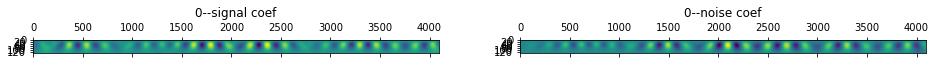

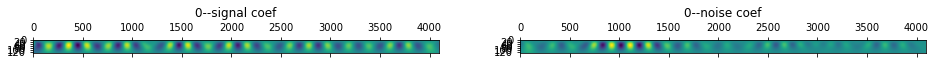

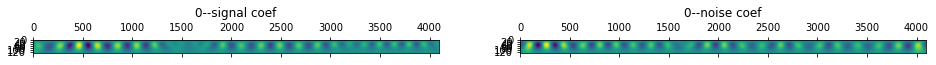

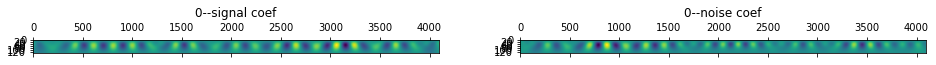

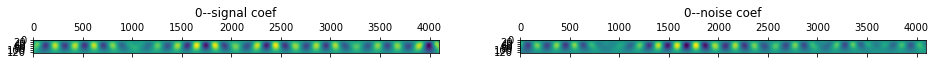

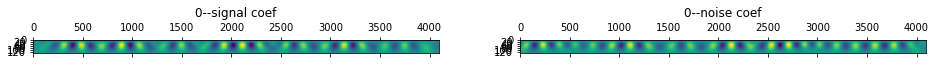

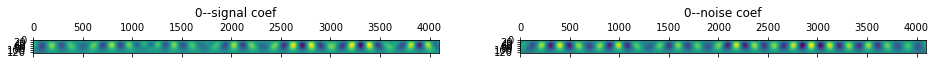

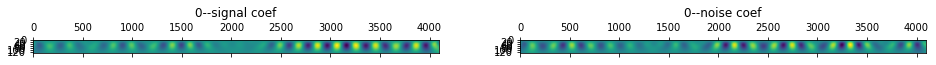

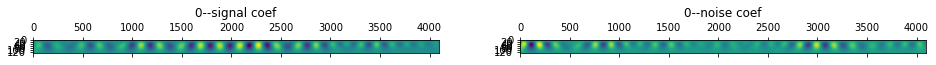

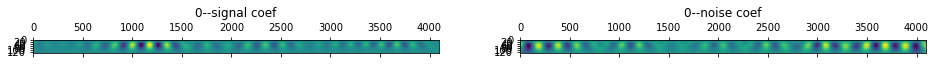

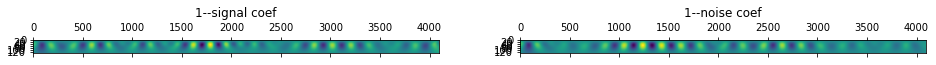

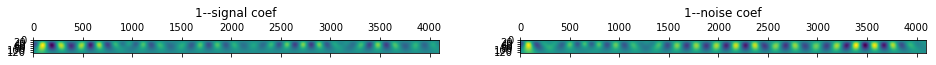

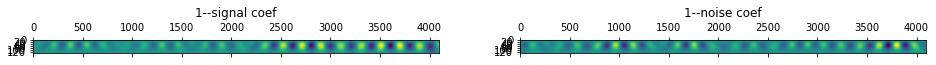

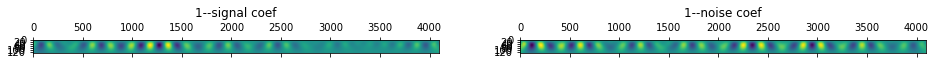

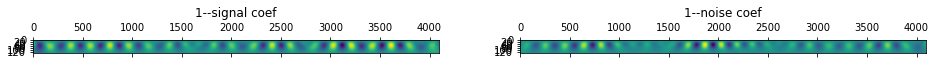

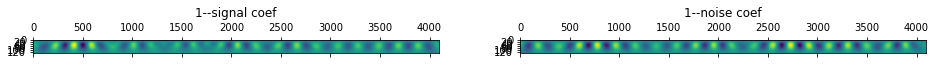

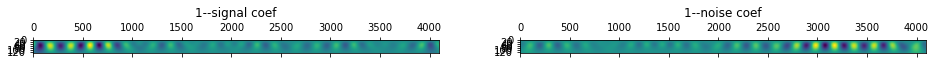

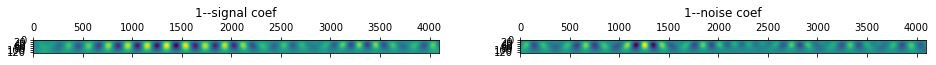

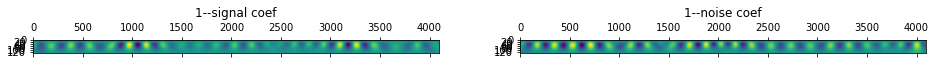

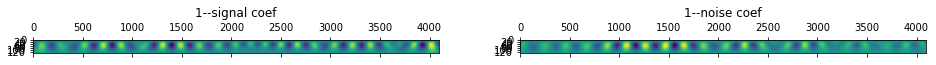

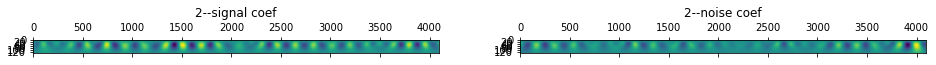

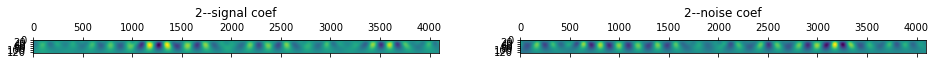

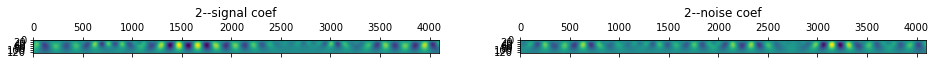

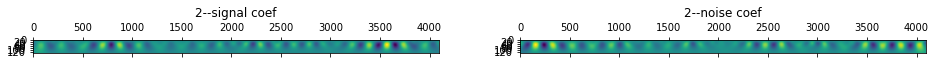

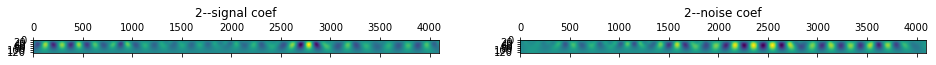

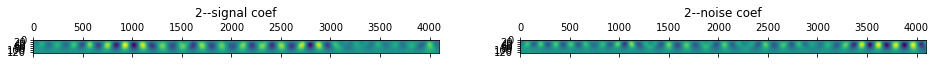

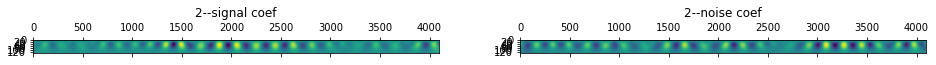

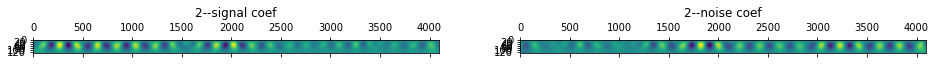

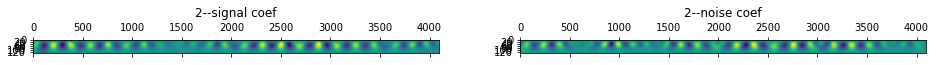

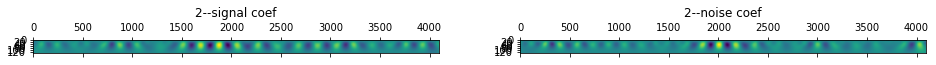

In [8]:
numComparisons = 10
#j=0 # Hanford
#j=1 # Livingston
#j=2 # Virgo
for j in range(3):
    for i in range(numComparisons):
        plotCoef(X_train_1, X_train_0, i, j)

In [32]:
def plotMatr(X_train_1, X_train_0, i, j, doFilter, doNormalize):
    widths = np.arange(1, 101)
    #widths = np.arange(1, 9)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 3)

    sig  = X_train_1[i][j][:]
    if doNormalize:
        sig = normalizeZ(sig)
    cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh') # 'mexh', 'morl'
    if doFilter:
        foo=1/freqs
        # Filter out freqs below 15Hz and above 500Hz
        idx_freq = np.where((foo > 20) & (foo <= 500))
        cwtmatr = cwtmatr[:,idx_freq]

    ax1.imshow(np.squeeze(cwtmatr), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
    ax1.set_title(str(j) + '--signal cwtmatr')

    sig  = X_train_0[i][j][:]
    if doNormalize:
        sig = normalizeZ(sig)
    cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh') # 'mexh', 'morl'
    if doFilter:
        foo=1/freqs
        # Filter out freqs below 15Hz and above 500Hz
        idx_freq = np.where((foo > 20) & (foo <= 500))
        cwtmatr = cwtmatr[:,idx_freq]
    ax2.imshow(np.squeeze(cwtmatr), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
    ax2.set_title(str(j) + '--noise cwtmatr')


<ipython-input-19-c3d63e0d9f47>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


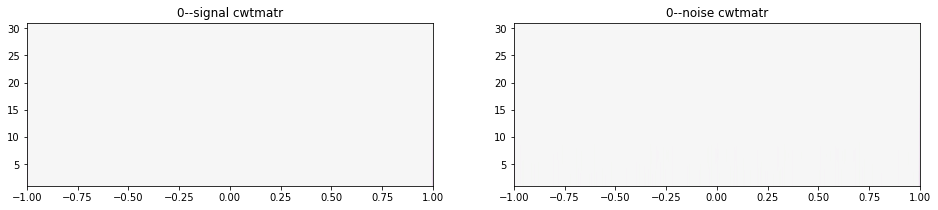

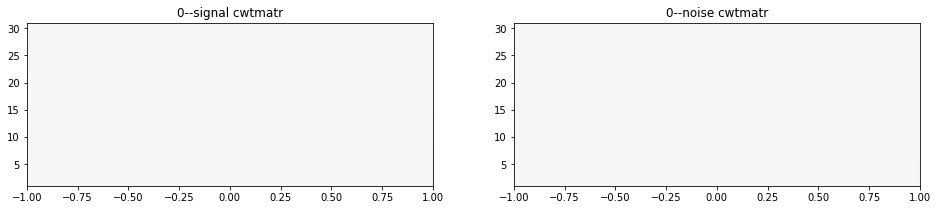

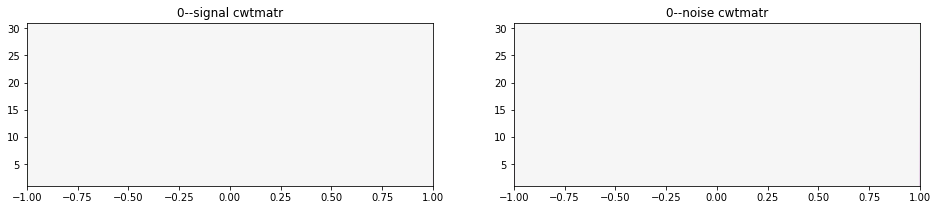

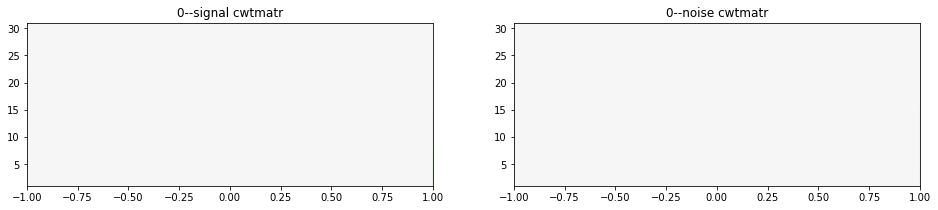

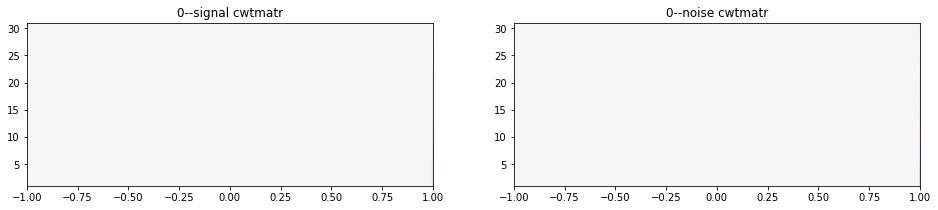

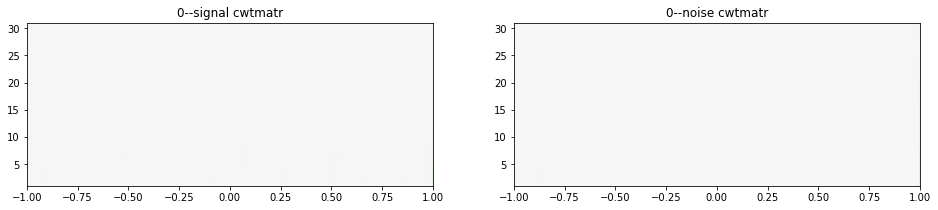

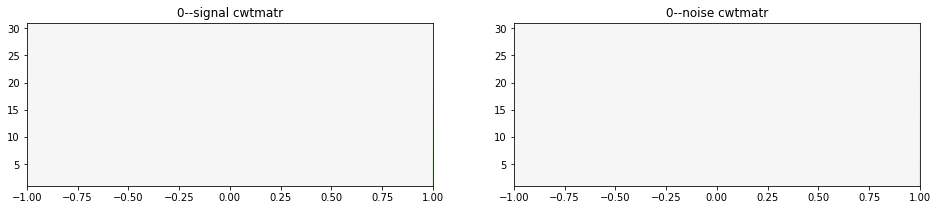

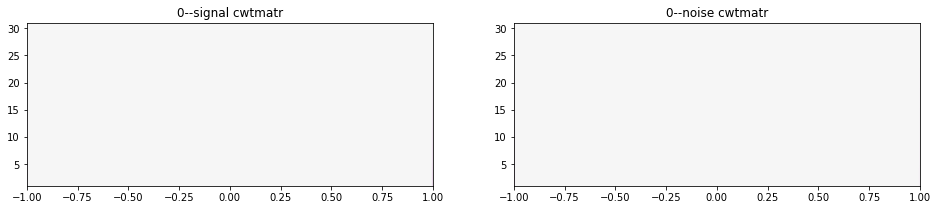

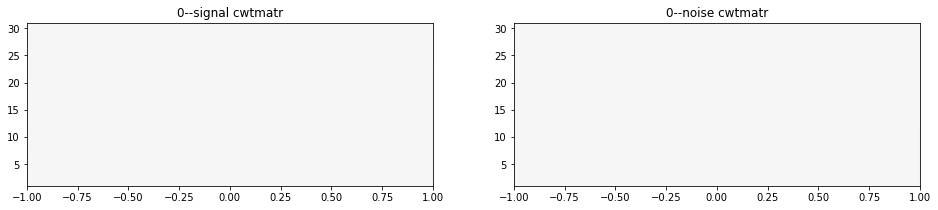

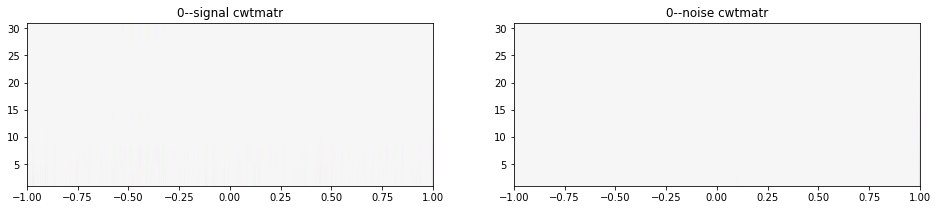

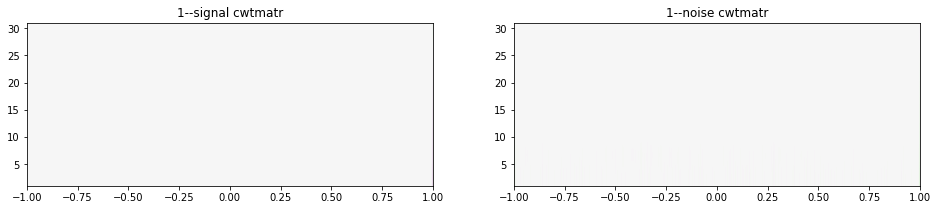

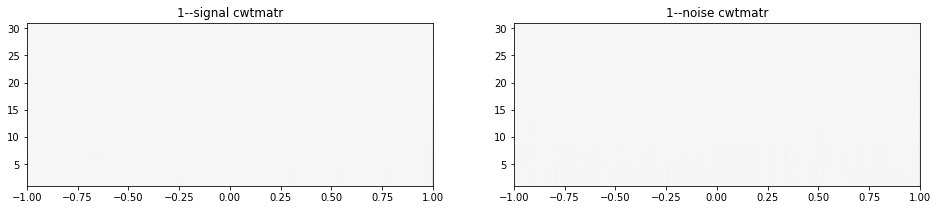

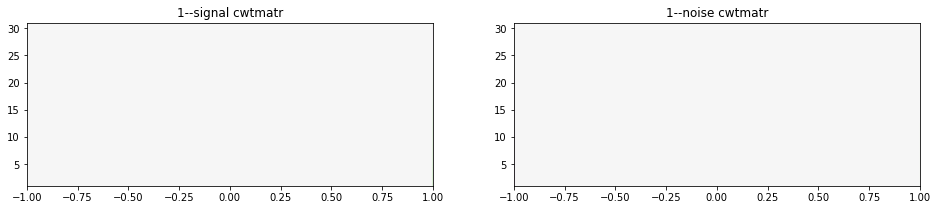

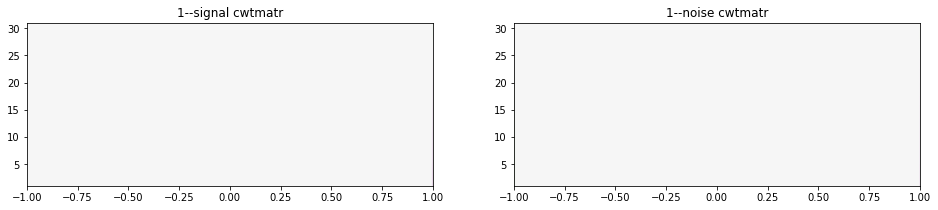

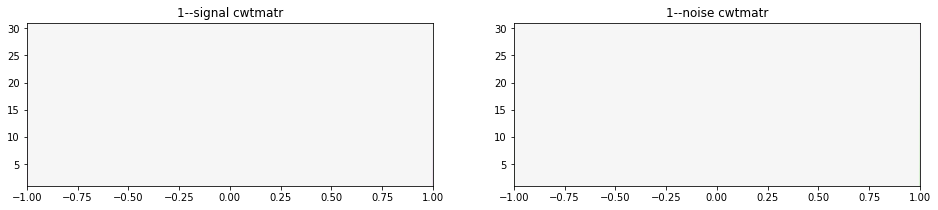

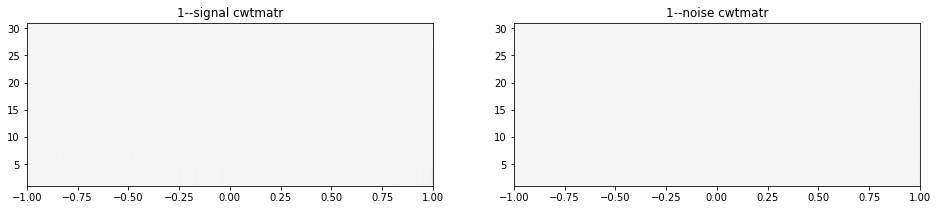

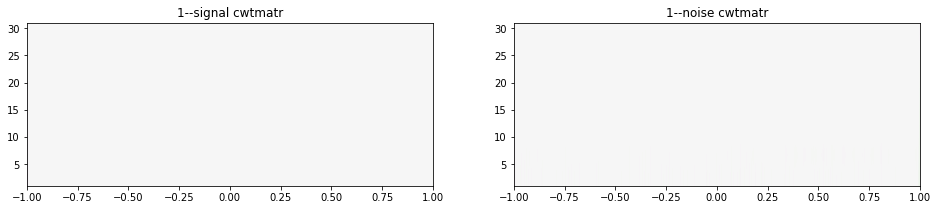

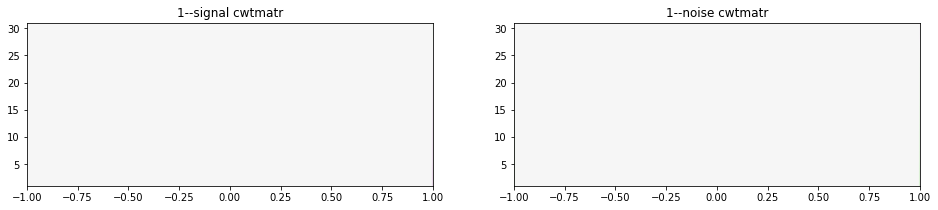

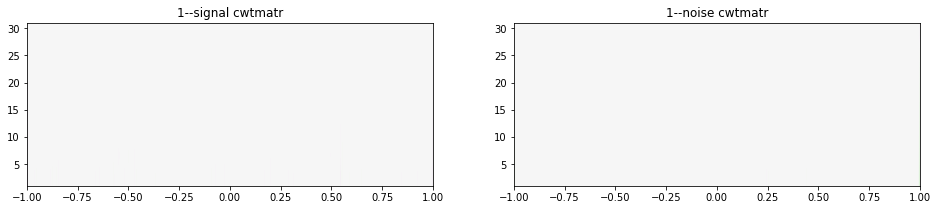

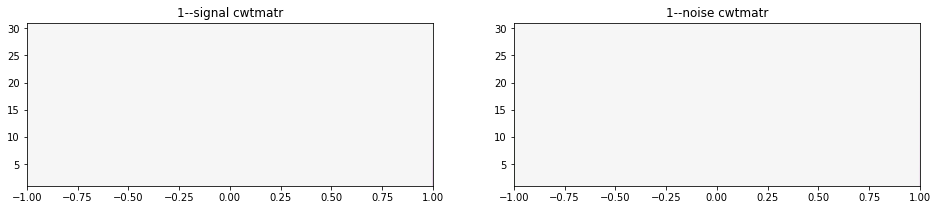

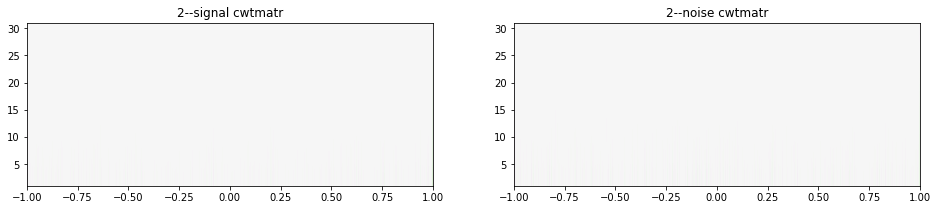

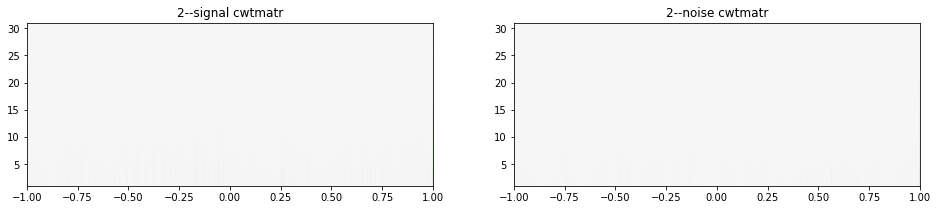

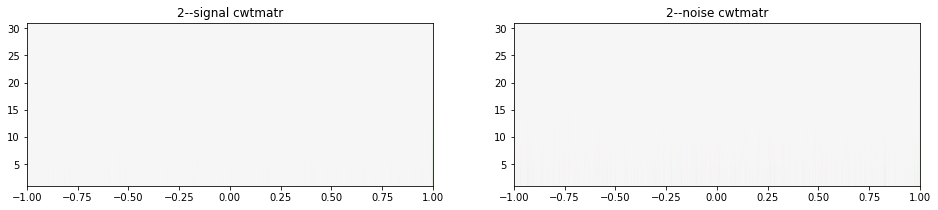

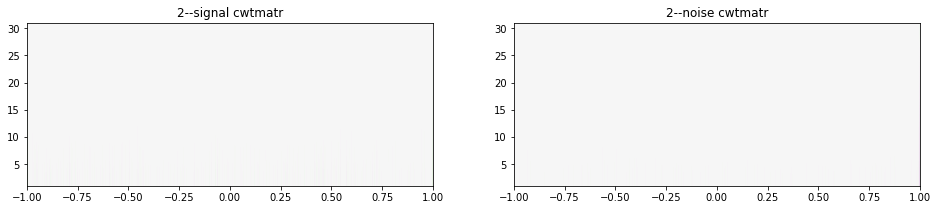

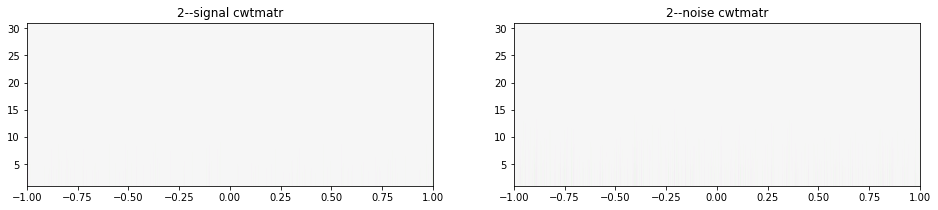

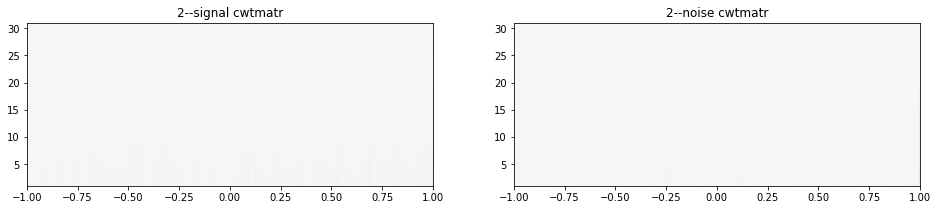

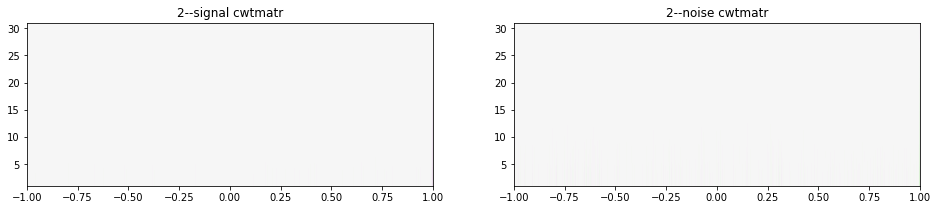

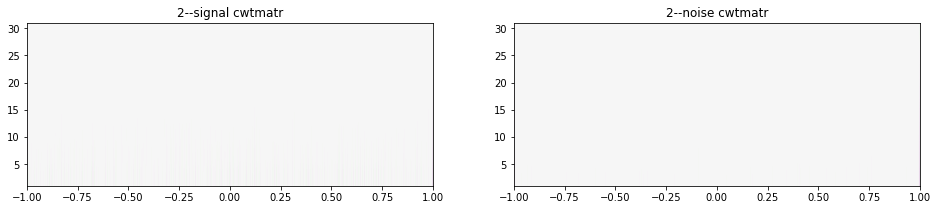

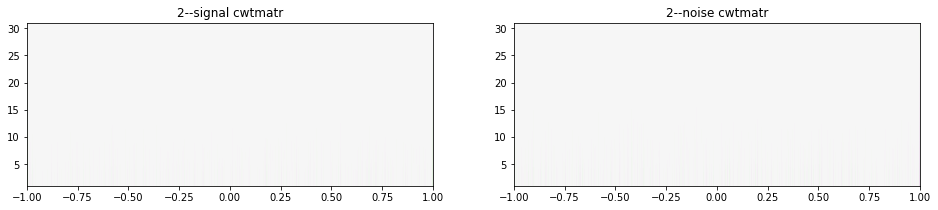

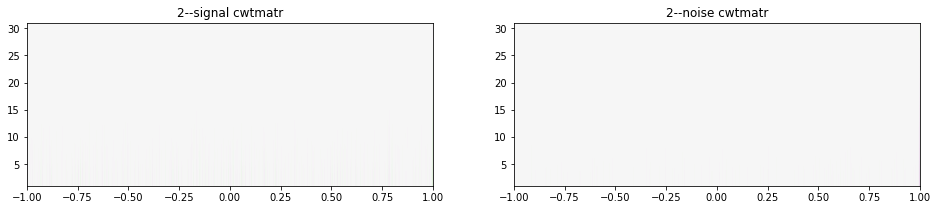

In [20]:
numComparisons = 10
#j=0 # Hanford
#j=1 # Livingston
#j=2 # Virgo
for j in range(3):
    for i in range(numComparisons):
        plotMatr(X_train_1, X_train_0, i, j, False, False)

<ipython-input-19-c3d63e0d9f47>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


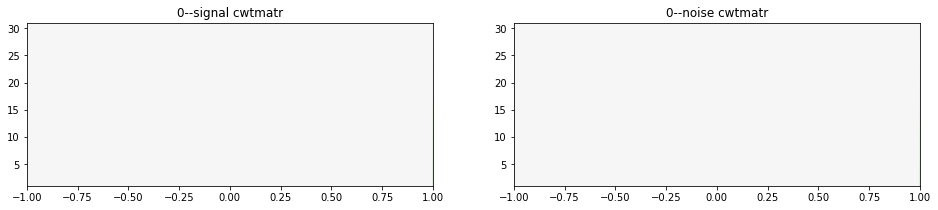

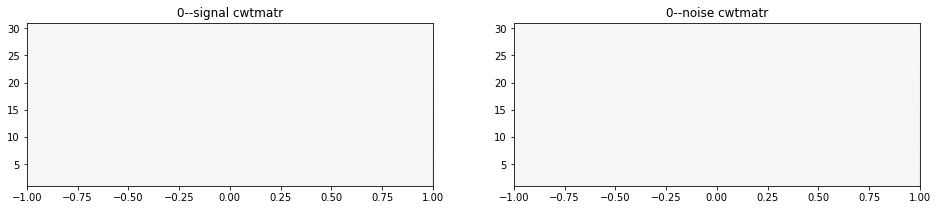

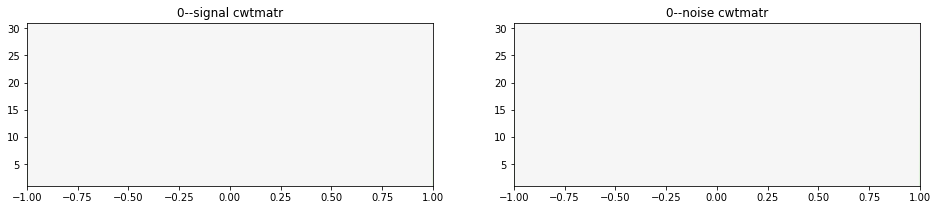

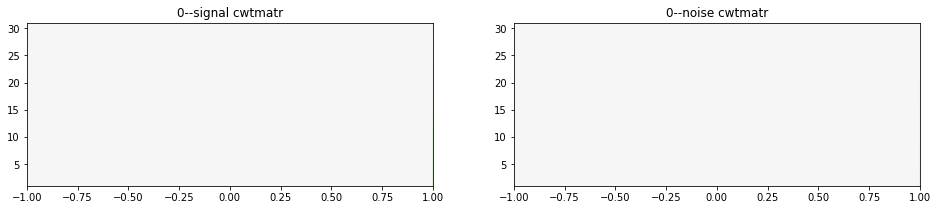

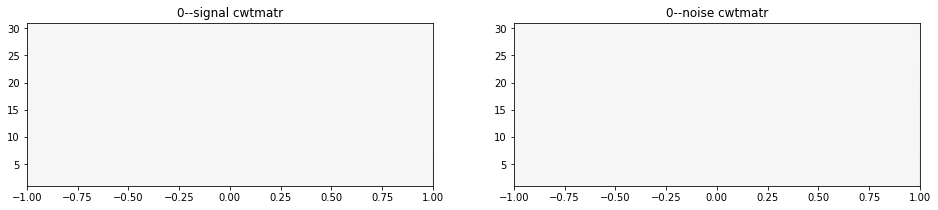

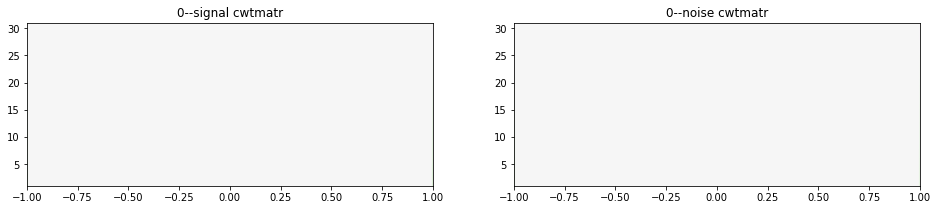

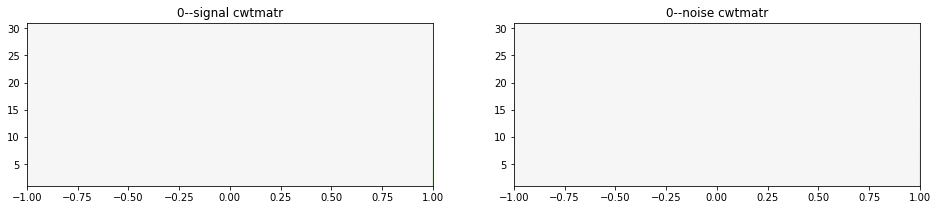

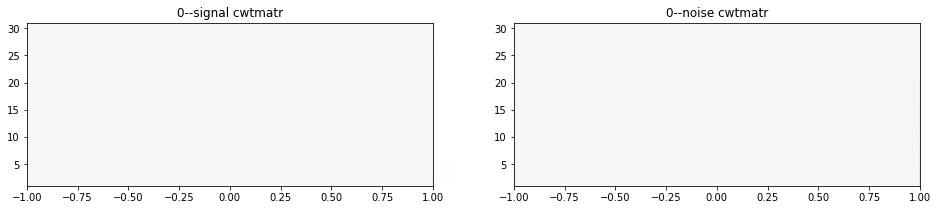

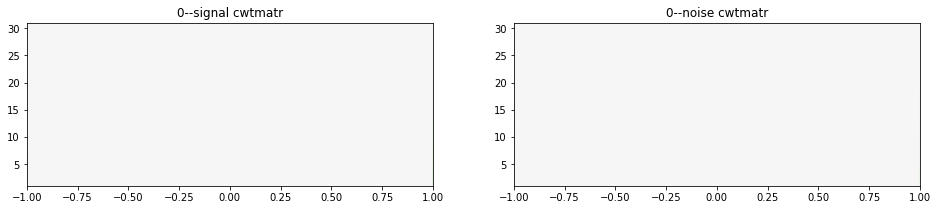

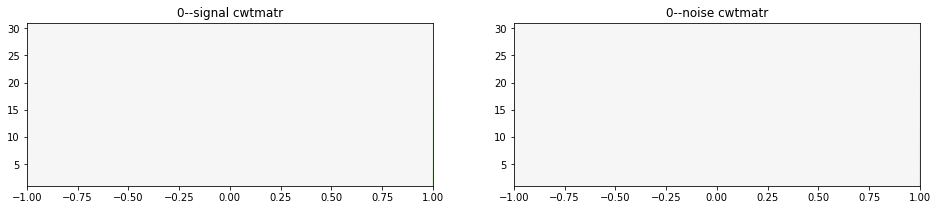

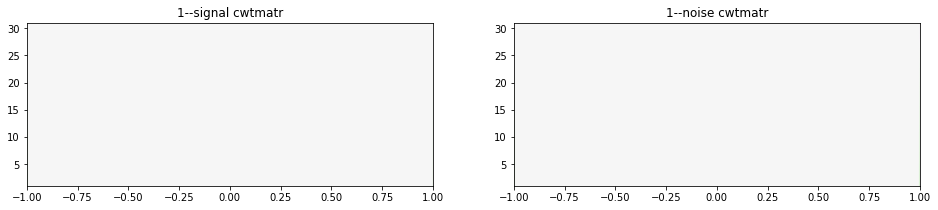

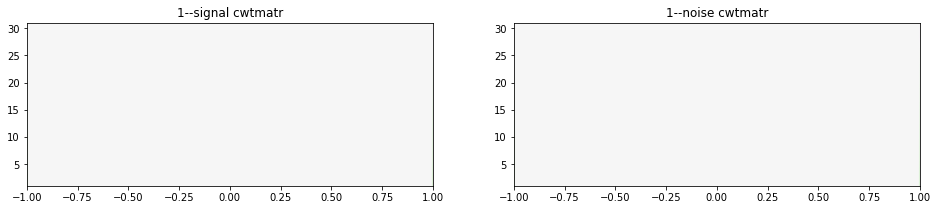

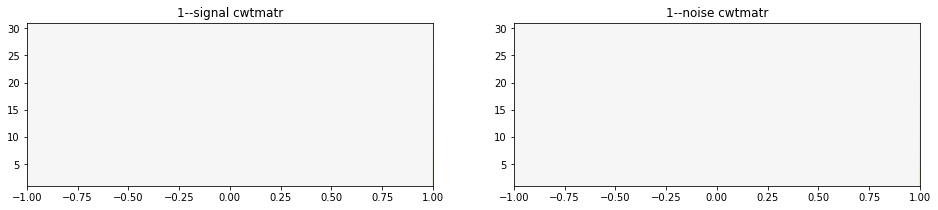

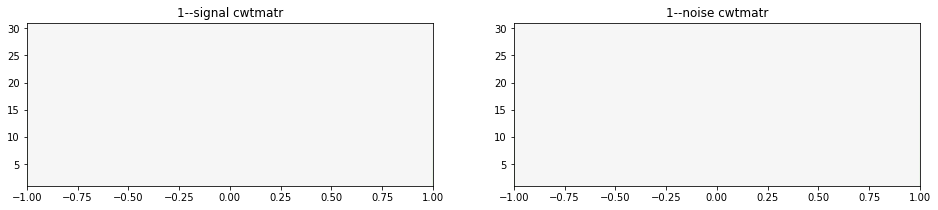

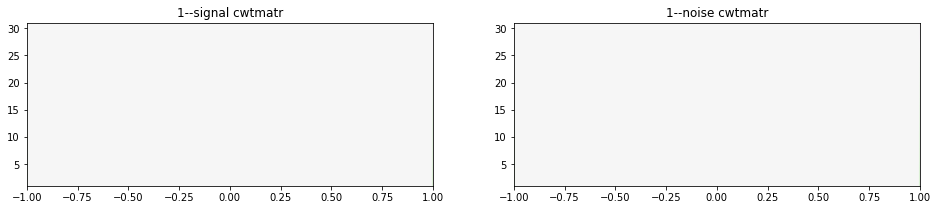

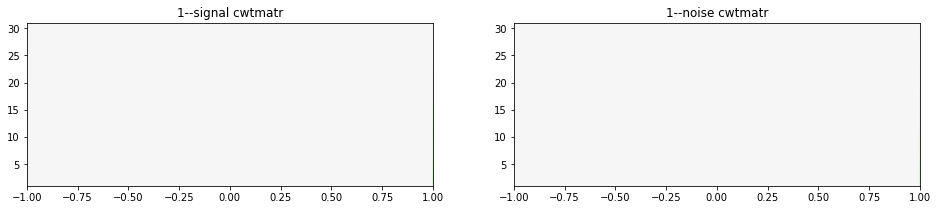

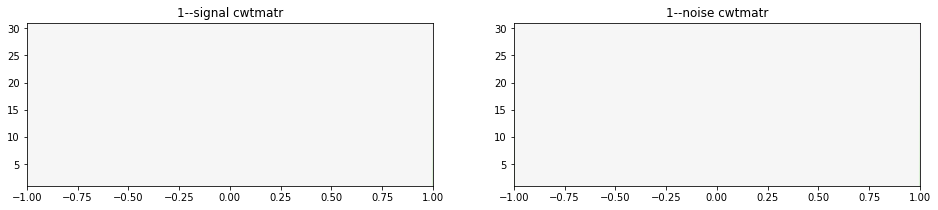

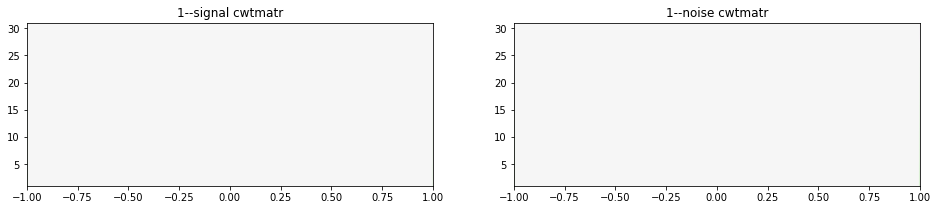

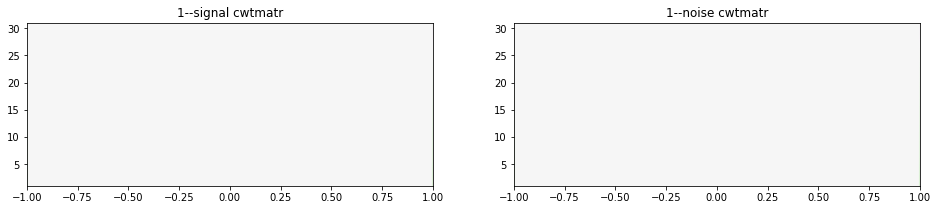

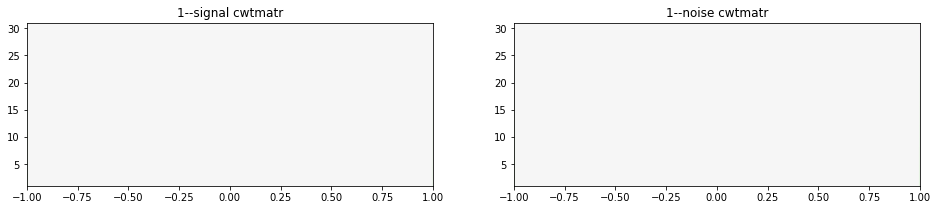

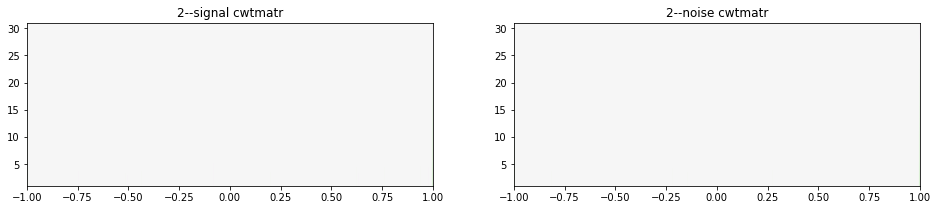

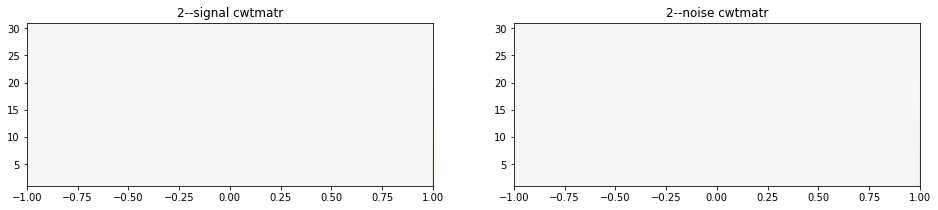

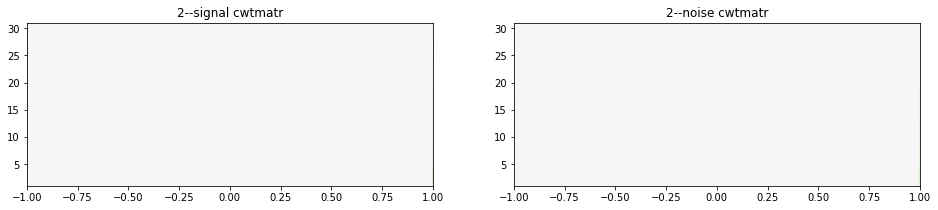

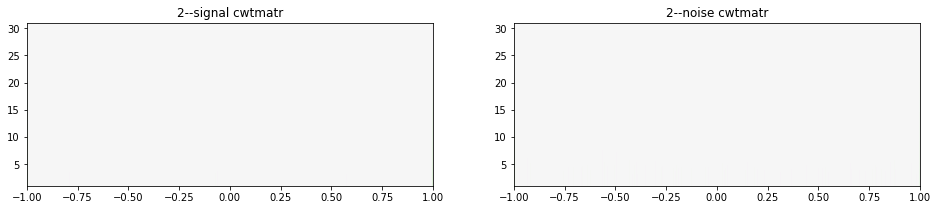

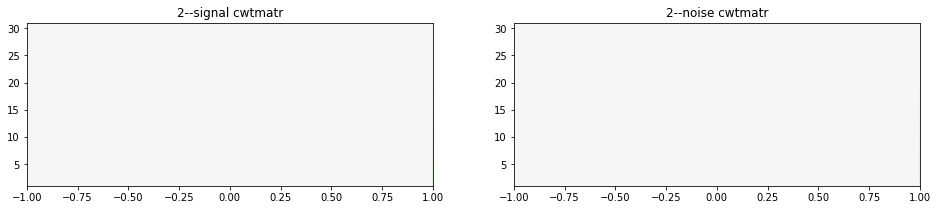

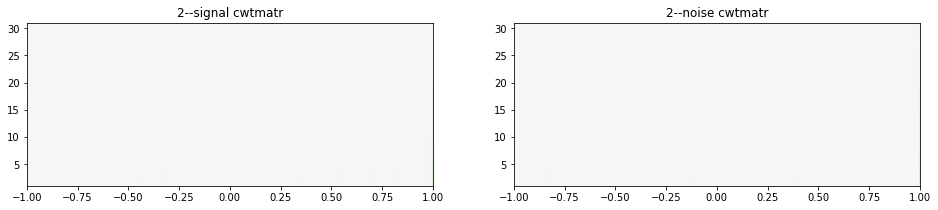

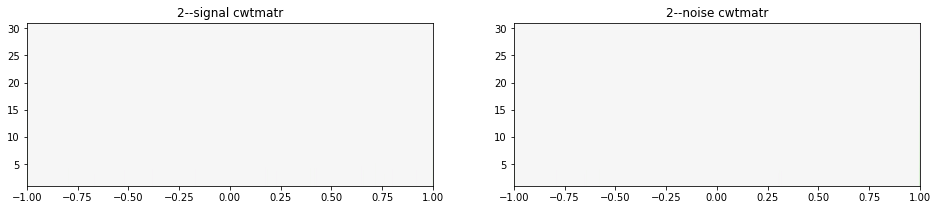

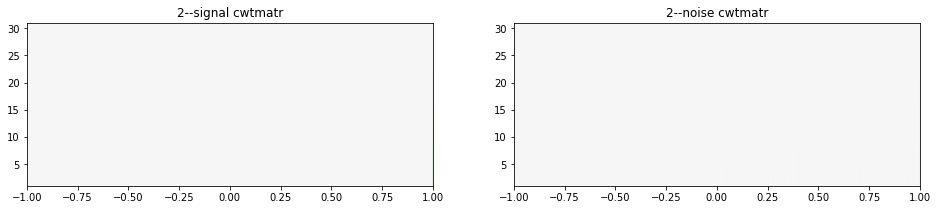

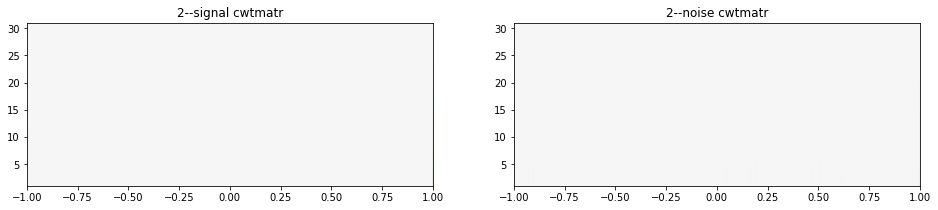

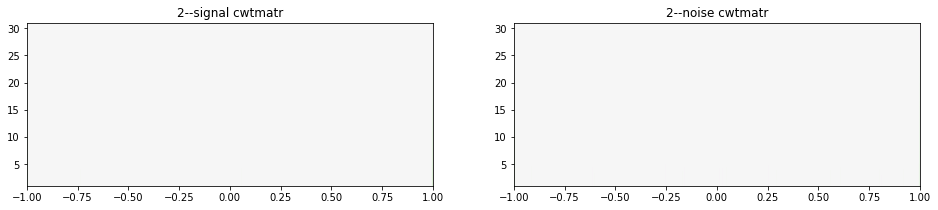

In [21]:
numComparisons = 10
#j=0 # Hanford
#j=1 # Livingston
#j=2 # Virgo
for j in range(3):
    for i in range(numComparisons):
        plotMatr(X_train_1, X_train_0, i, j, False, True)

<ipython-input-23-57ec14043192>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


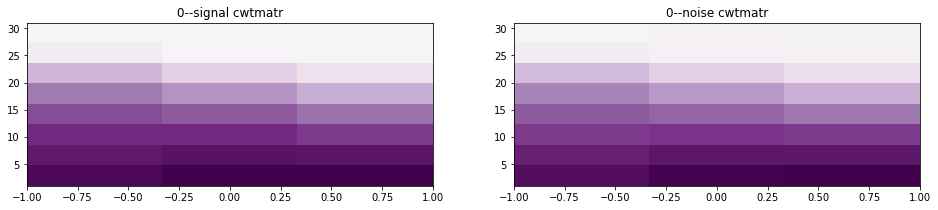

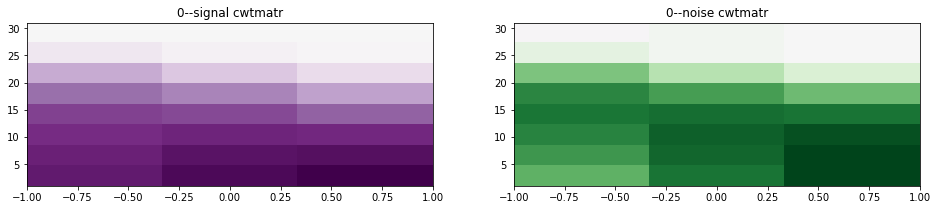

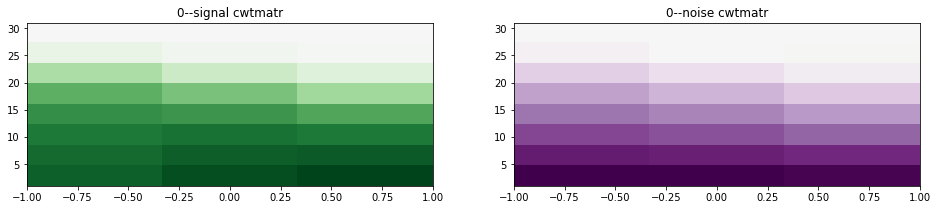

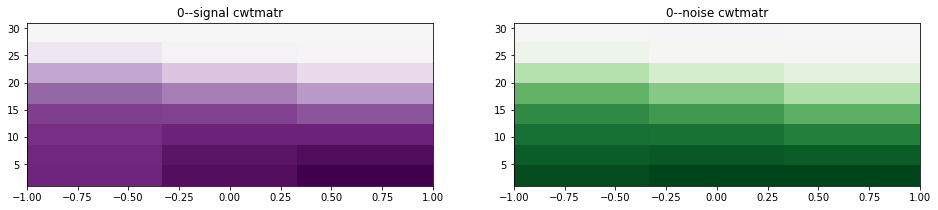

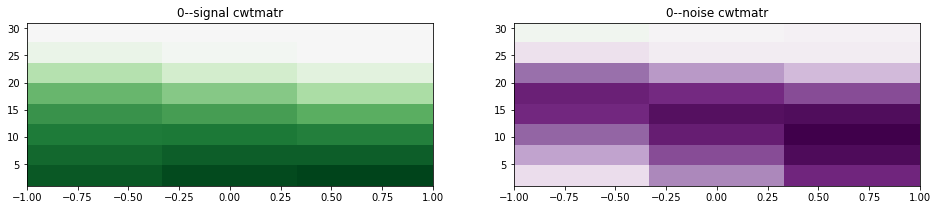

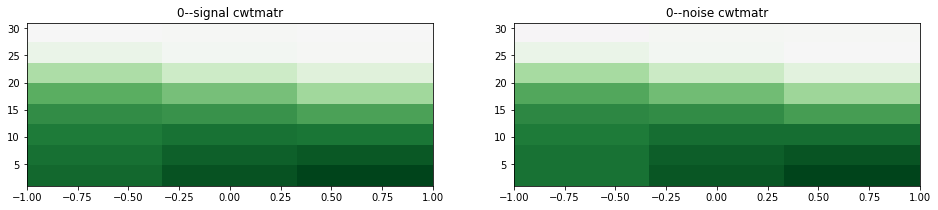

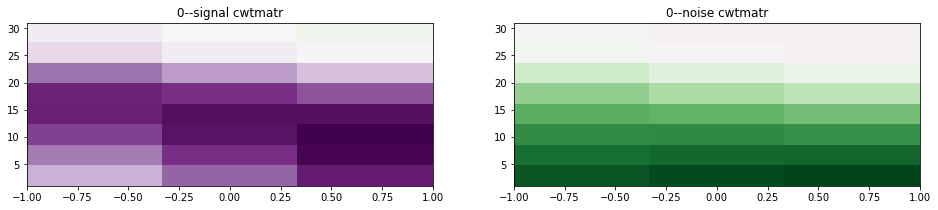

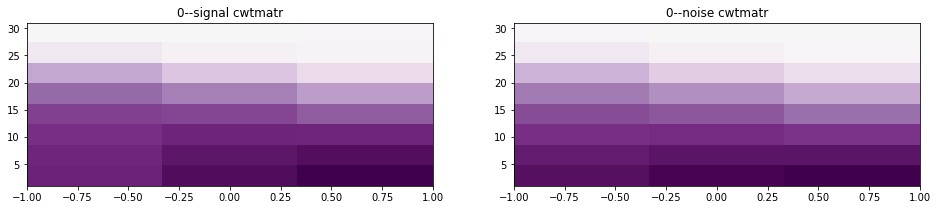

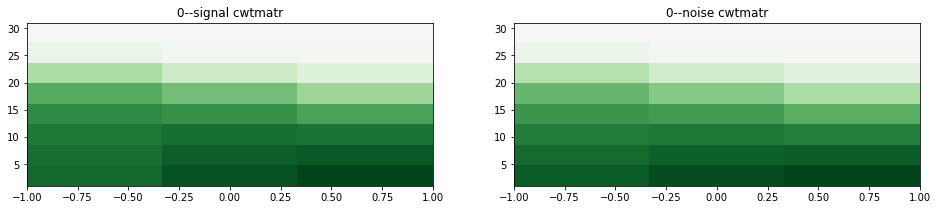

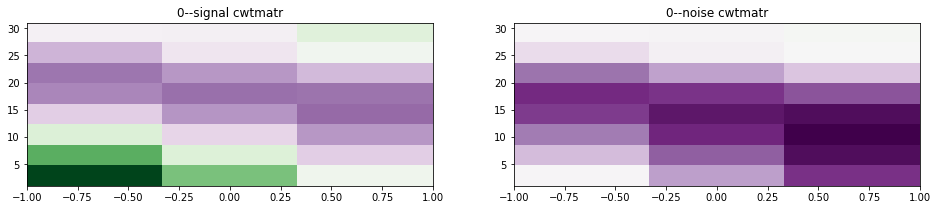

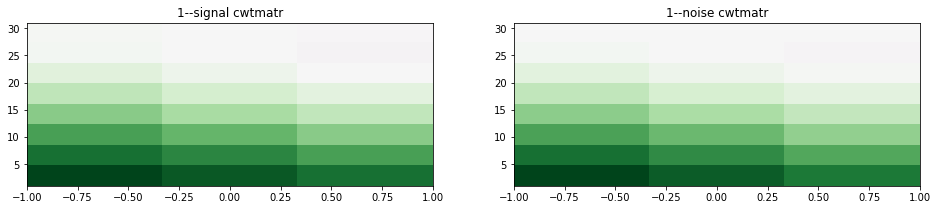

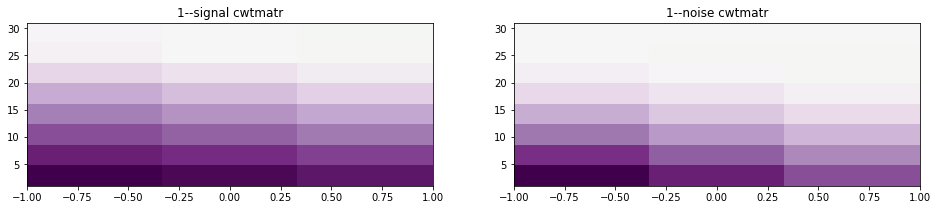

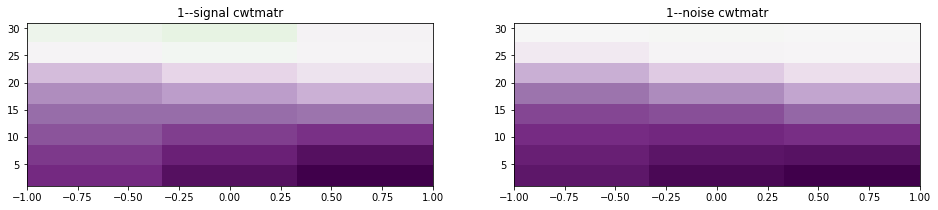

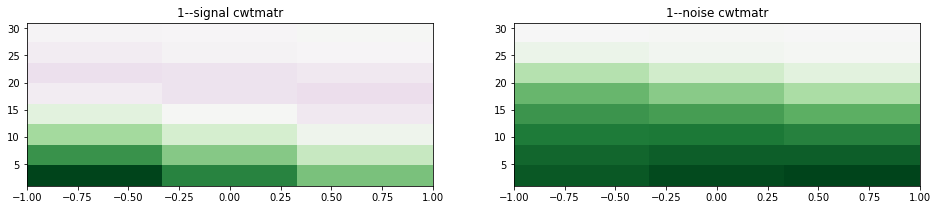

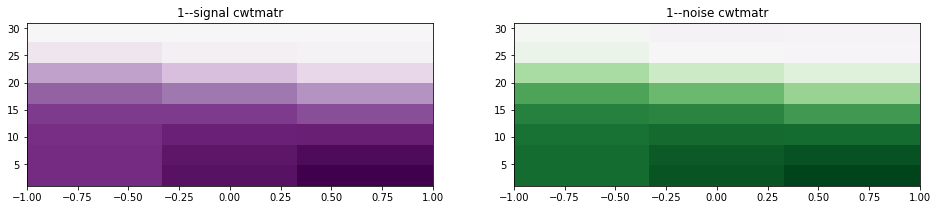

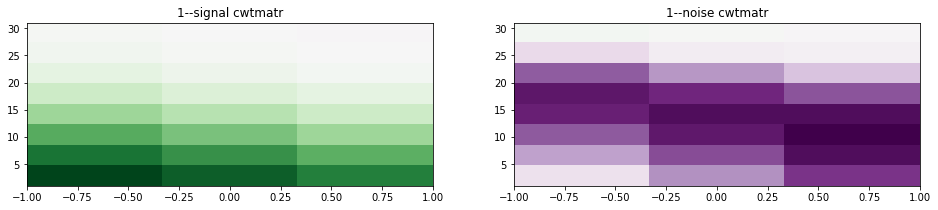

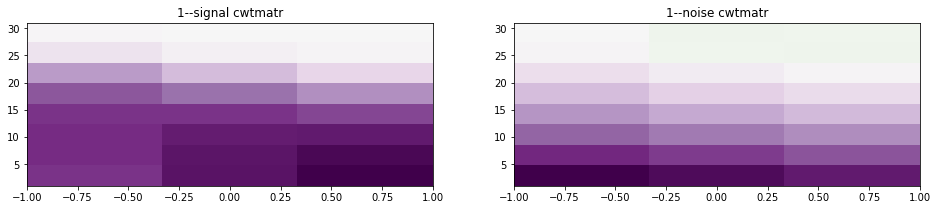

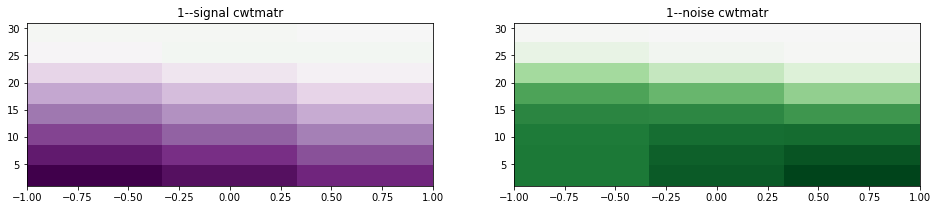

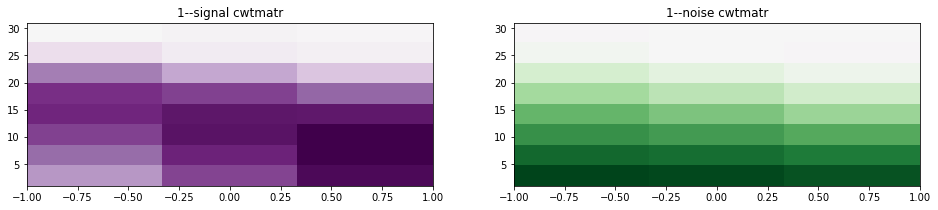

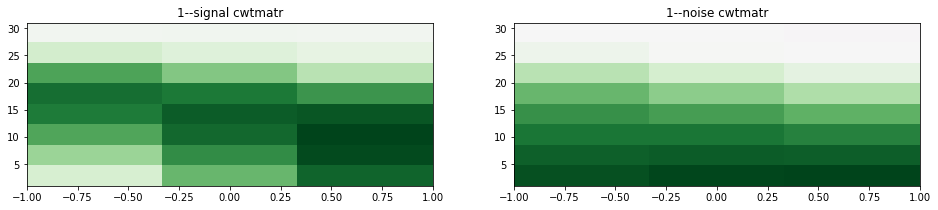

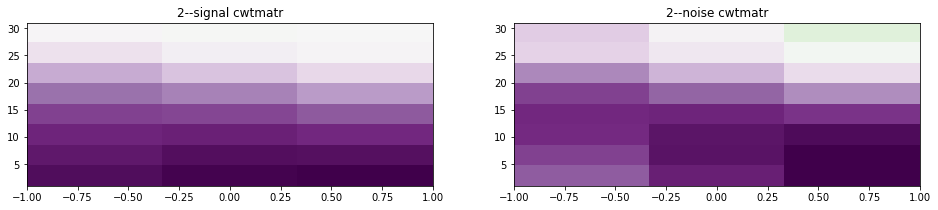

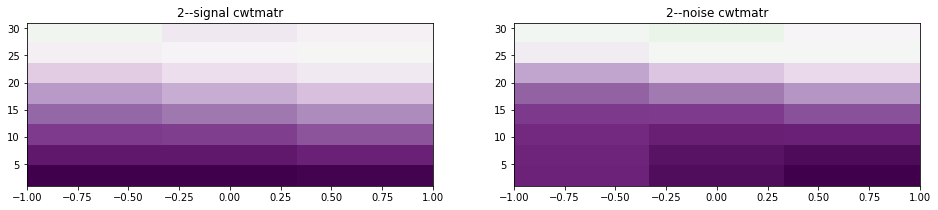

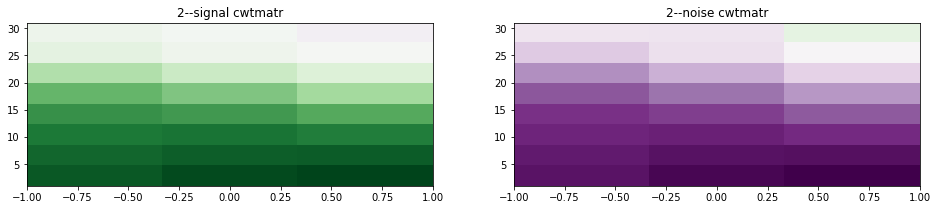

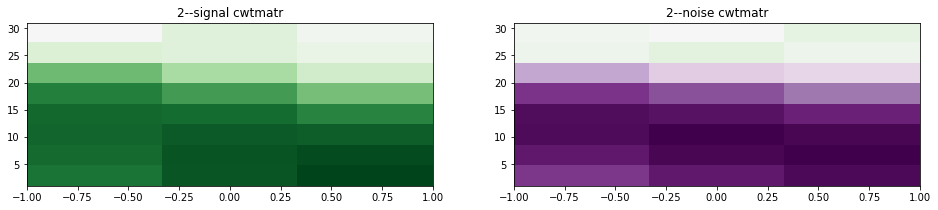

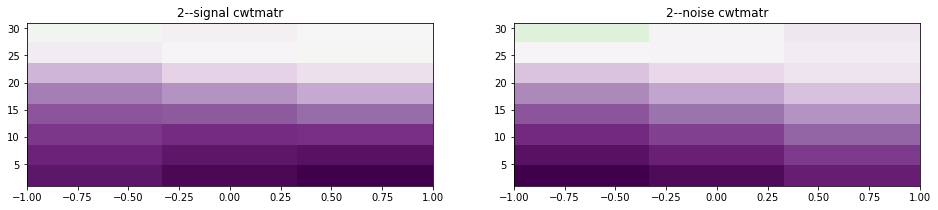

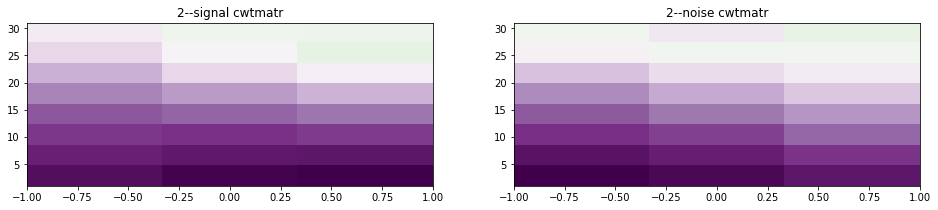

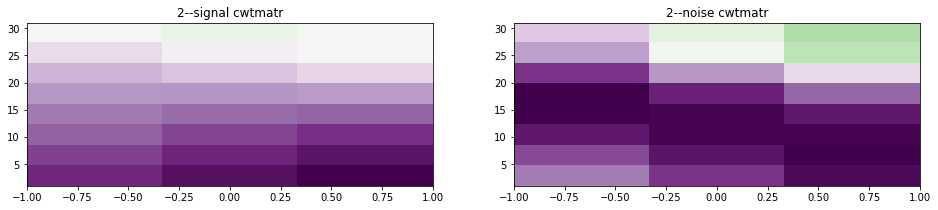

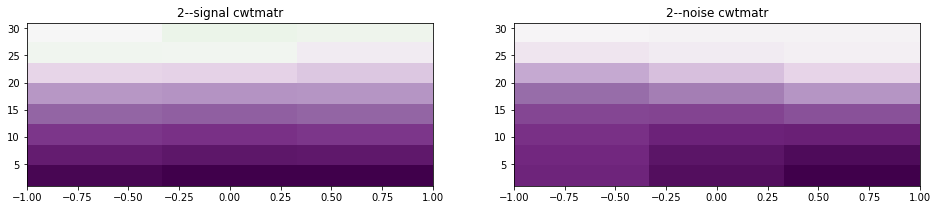

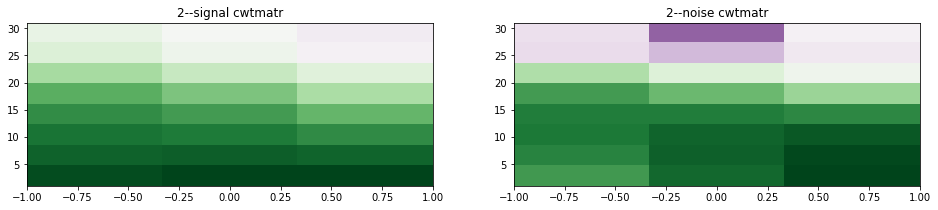

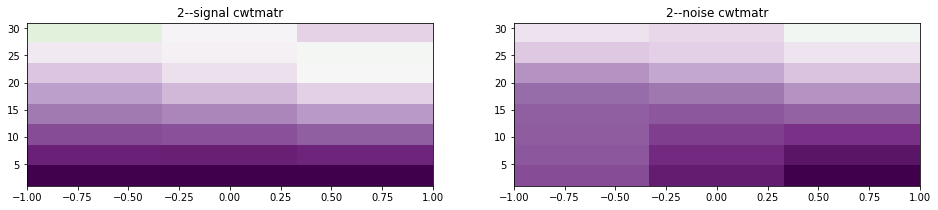

In [24]:
numComparisons = 10
#j=0 # Hanford
#j=1 # Livingston
#j=2 # Virgo
for j in range(3):
    for i in range(numComparisons):
        plotMatr(X_train_1, X_train_0, i, j, True, False)

<ipython-input-32-a9e9a8f14db1>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


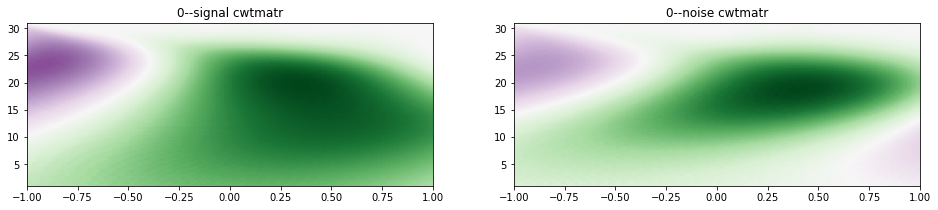

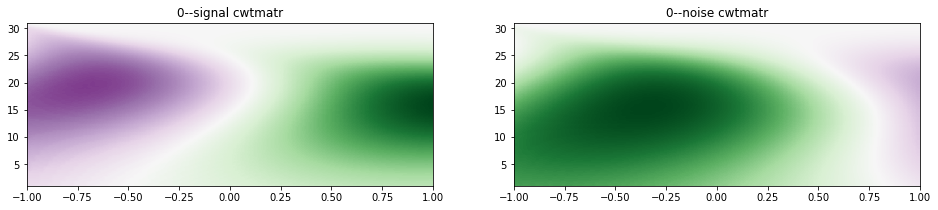

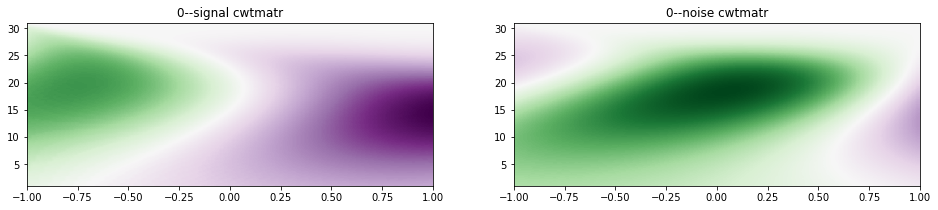

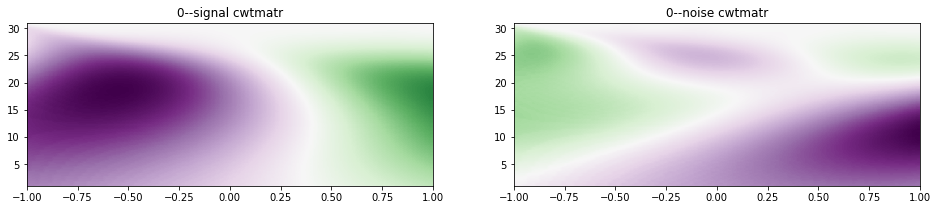

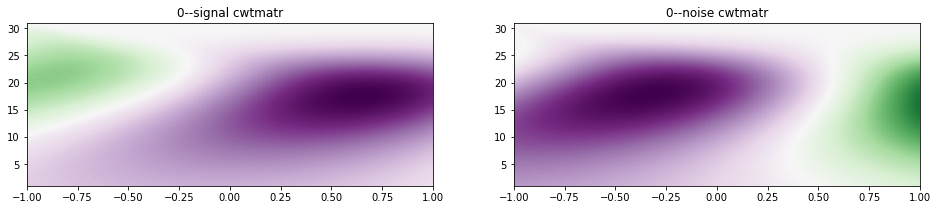

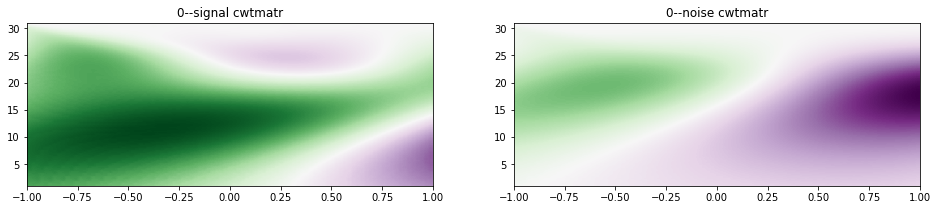

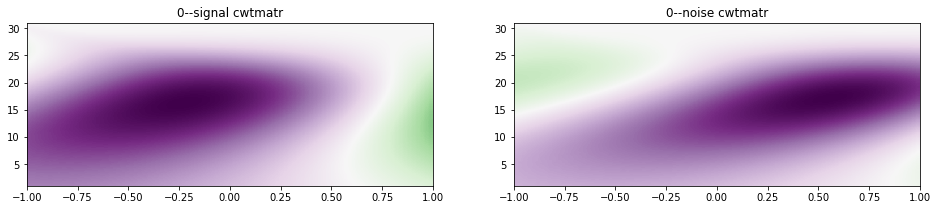

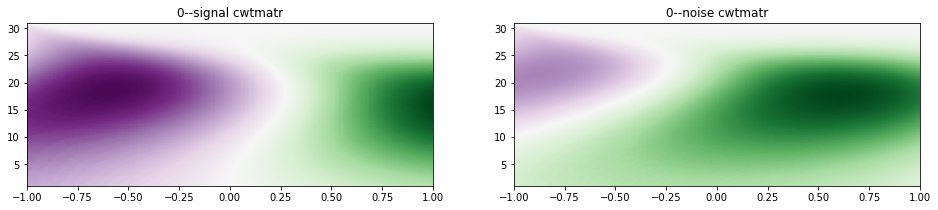

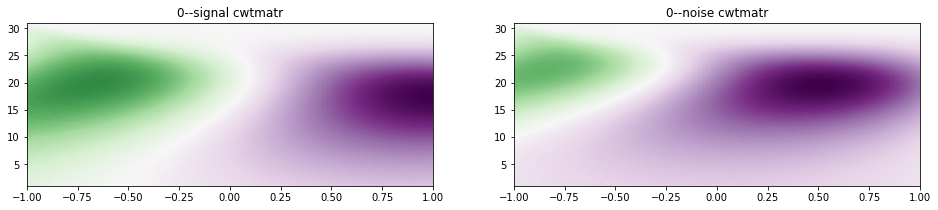

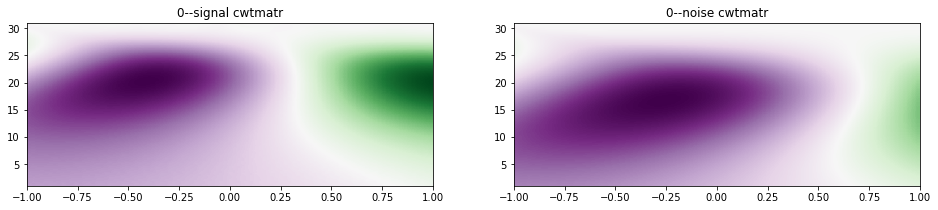

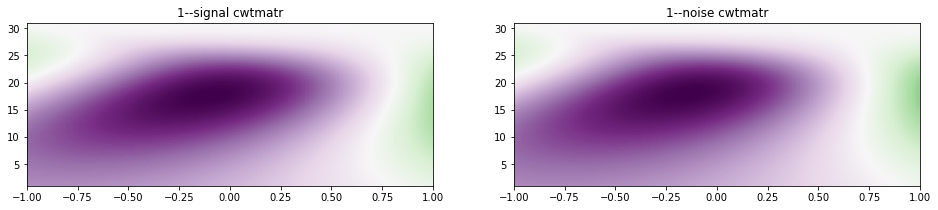

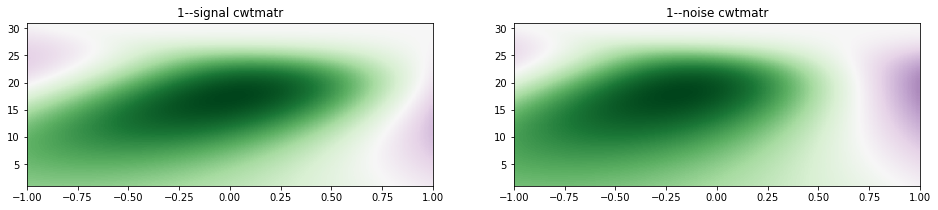

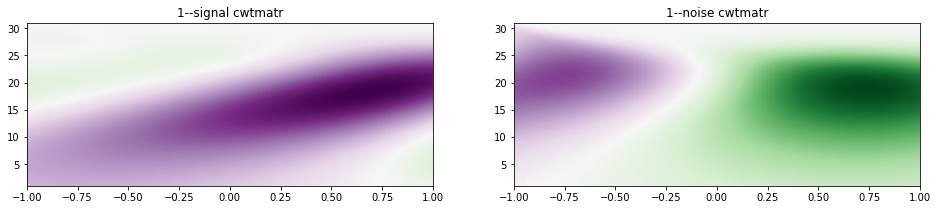

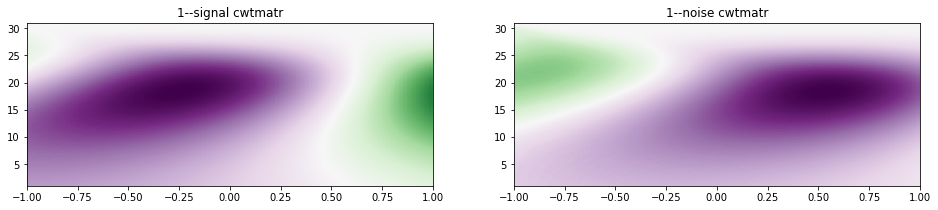

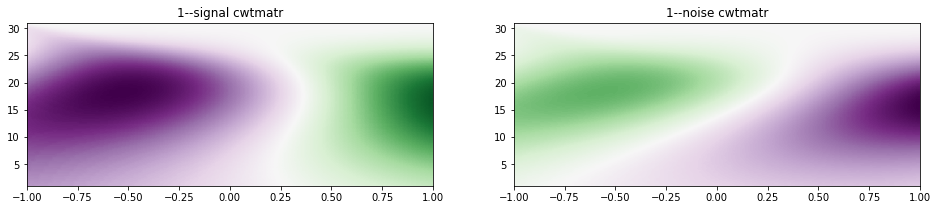

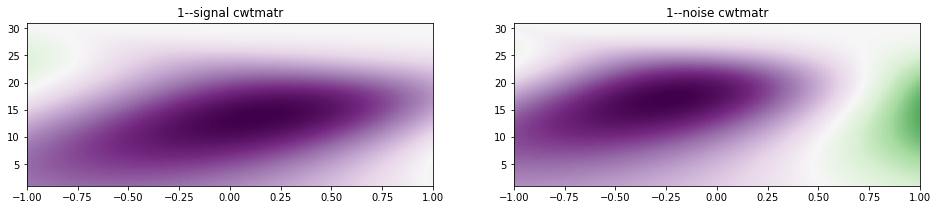

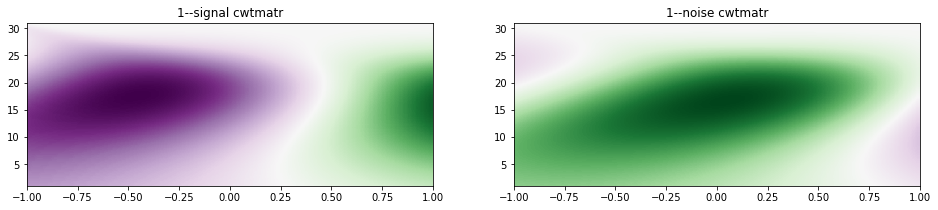

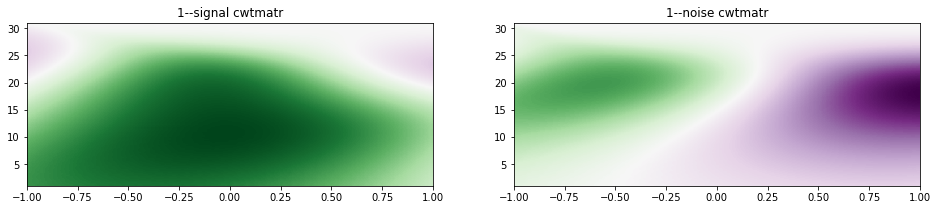

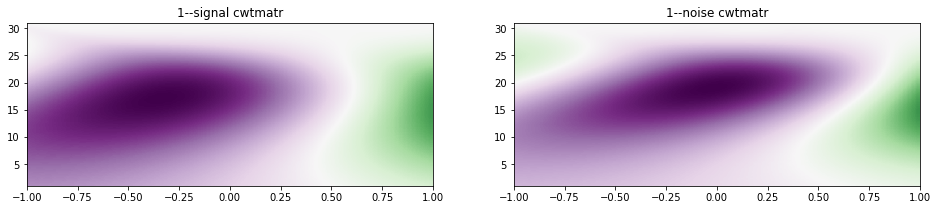

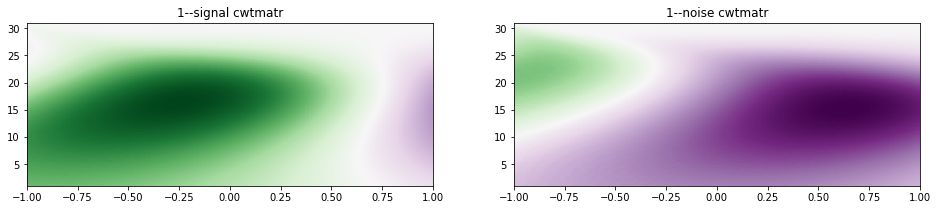

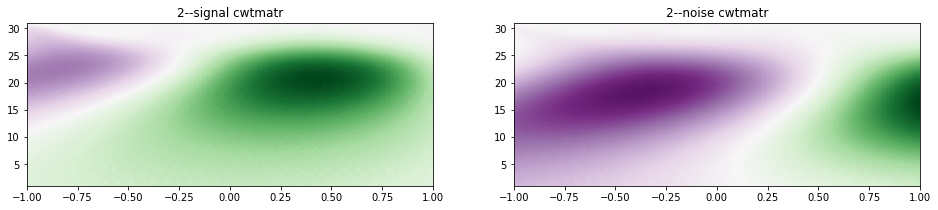

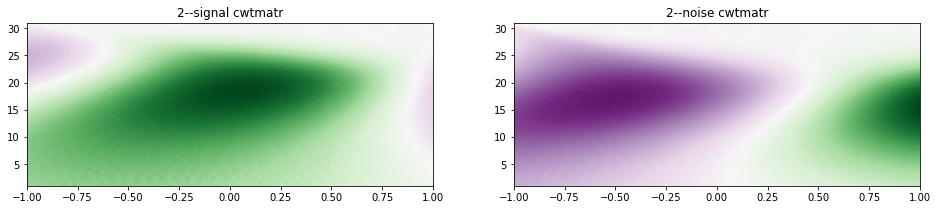

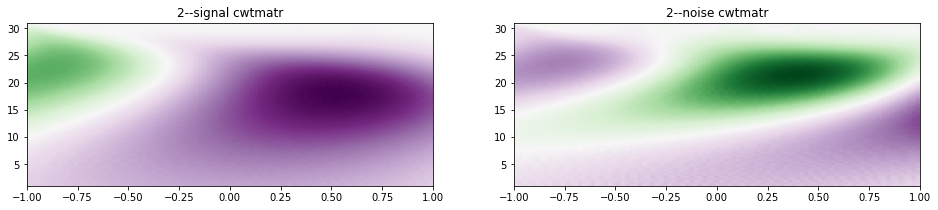

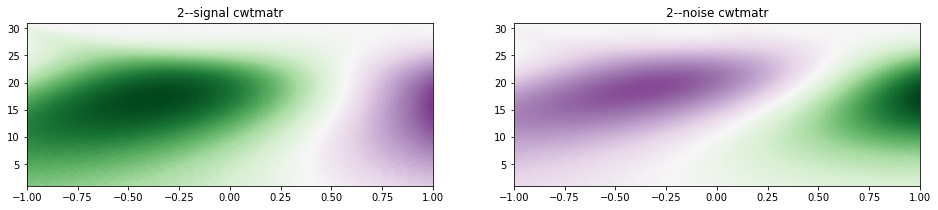

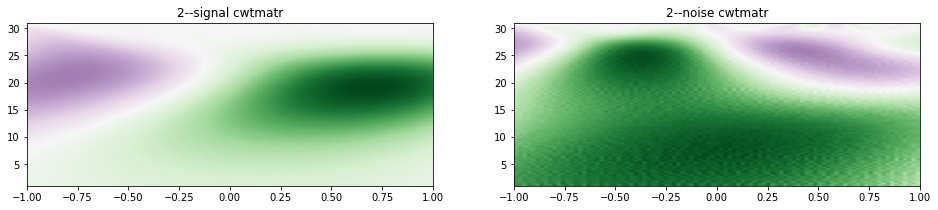

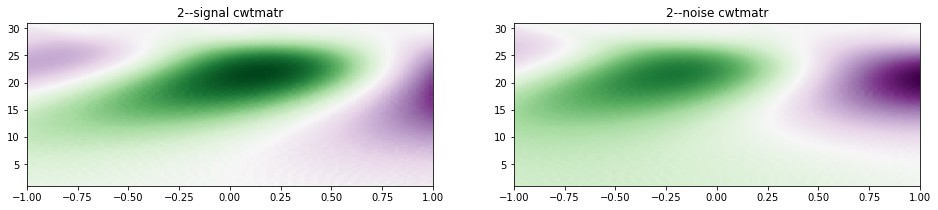

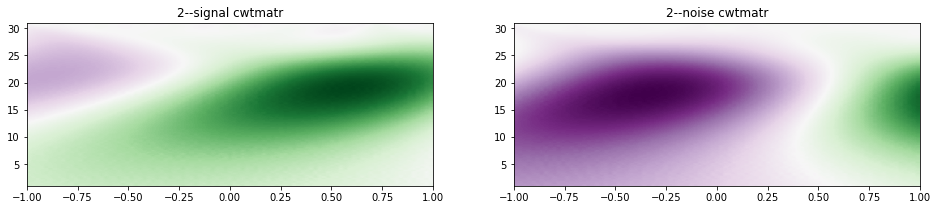

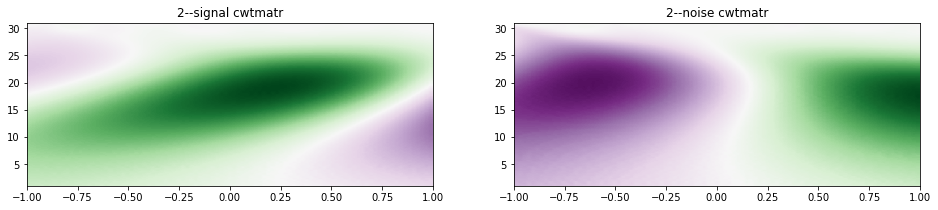

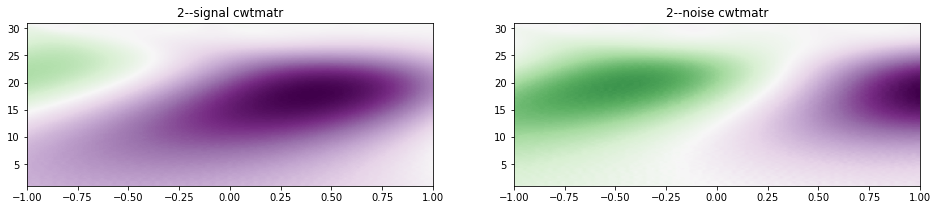

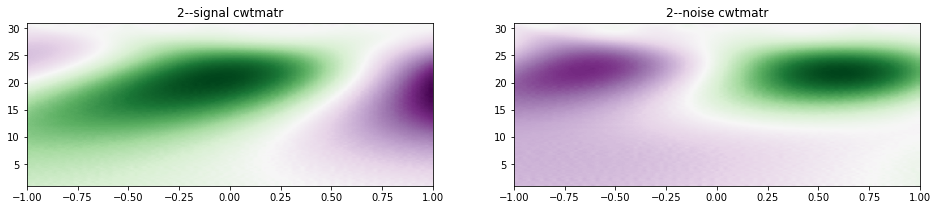

In [33]:
numComparisons = 10
#j=0 # Hanford
#j=1 # Livingston
#j=2 # Virgo
for j in range(3):
    for i in range(numComparisons):
        plotMatr(X_train_1, X_train_0, i, j, True, True)

In [ ]:
wavelet='gaus1'
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 3)
foo = X_train_1[i][0][:]
print("idx shape")
print(idx.shape)
print("sample shape")
print(foo.shape)

numComparisons = 10
idx = np.arange(0, 4096, 1)
wavelet='gaus1'
for i in range(numComparisons):
    plotSignal(idx, X_train_1[i], X_train_0[i])

ax1.plot(idx, normalize(X_train_1[i][0][:]), label='Hanford')
ax1.plot(idx, normalize(X_train_1[i][1][:]), label='Livingston')
ax1.plot(idx, normalize(X_train_1[i][2][:]), label='Virgo')
ax1.set_title('signal-normalized')

ax2.plot(idx, normalize(X_train_0[i][0][:]), label='Hanford')
ax2.plot(idx, normalize(X_train_0[i][1][:]), label='Livingston')
ax2.plot(idx, normalize(X_train_0[i][2][:]), label='Virgo')
ax2.set_title('noise-normalized')

print("Plot out coef as image, CWT gaus1")
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
y = X_train_1[i][j][:]
coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
print("shape of coef")
print(coef.shape)
print("shape of freqs")
print(freqs.shape)
#ax1.matshow(coef)
ax1.imshow(coef) # doctest: +SKIP
ax1.set_title(str(j) + '--signal coef')

y = X_train_0[i][j][:]
coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
ax2.imshow(coef) # doctest: +SKIP
#ax2.matshow(coef) # doctest: +SKIP
ax2.set_title(str(j) + '--noise coef')

print("Plot out CWT with widths/mexh")
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 3)

sig  = X_train_1[j][0][:]
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
print("cwtmatr shape")
print(cwtmatr.shape)
print("freqs shape")
print(freqs.shape)
ax1.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
ax1.set_title(str(j) + '--signal cwtmatr')

sig  = X_train_0[j][0][:]
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
ax2.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
ax2.set_title(str(j) + '--noise cwtmatr')


In [ ]:
# Compare signal vs noise, as many as desired

numComparisons = 1
#idx = range(0, 4096)
#idx = np.asarray(np.linspace(0, 4096, 4096))
idx = np.arange(0, 4096, 1)
wavelet='gaus1'
for i in range(numComparisons):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 3)
    print(idx.shape)
    foo = X_train_1[i][0][:]
    print(foo.shape)

    ax1.plot(idx, X_train_1[i][0][:], label='Hanford')
    ax1.plot(idx, X_train_1[i][1][:], label='Livingston')
    ax1.plot(idx, X_train_1[i][2][:], label='Virgo')
    ax1.set_title('Run ' + str(i) + '-signal')

    ax2.plot(idx, X_train_0[i][0][:], label='Hanford')
    ax2.plot(idx, X_train_0[i][1][:], label='Livingston')
    ax2.plot(idx, X_train_0[i][2][:], label='Virgo')
    ax2.set_title('Run ' + str(i) + '-noise')

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 3)

    ax1.plot(idx, normalize(X_train_1[i][0][:]), label='Hanford')
    ax1.plot(idx, normalize(X_train_1[i][1][:]), label='Livingston')
    ax1.plot(idx, normalize(X_train_1[i][2][:]), label='Virgo')
    ax1.set_title('signal-normalized')

    ax2.plot(idx, normalize(X_train_0[i][0][:]), label='Hanford')
    ax2.plot(idx, normalize(X_train_0[i][1][:]), label='Livingston')
    ax2.plot(idx, normalize(X_train_0[i][2][:]), label='Virgo')
    ax2.set_title('noise-normalized')

    #widths = np.arange(1, 101)
    widths = np.arange(1, 8)
    t = np.linspace(-1, 1, 200, endpoint=False)
    for j in range(3):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(16, 3)
        y = X_train_1[i][j][:]
        coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
        print(coef.shape)
        print(freqs.shape)
        ax1.matshow(coef) # doctest: +SKIP
        ax1.set_title(str(j) + '--signal coef')

        y = X_train_0[i][j][:]
        coef, freqs=pywt.cwt(y,np.arange(1,129),wavelet)
        ax2.matshow(coef) # doctest: +SKIP
        ax2.set_title(str(j) + '--noise coef')

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(16, 3)

        sig  = X_train_1[j][0][:]
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        #print(cwtmatr.shape)
        #print(freqs.shape)
        ax1.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax1.set_title(str(j) + '--signal cwtmatr')

        sig  = X_train_0[j][0][:]
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        #print(cwtmatr.shape)
        #print(freqs.shape)
        ax2.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax2.set_title(str(j) + '--noise cwtmatr')

        foo=1/freqs
        # Filter out freqs below 15Hz and above 500Hz
        idx_freq = np.where((foo > 15) & (foo <= 500))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(16, 3)

        sig  = normalize(X_train_1[j][0][:])
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        cwtmatr = cwtmatr[:,idx_freq]
        print('this')
        print(cwtmatr.shape)
        print(freqs.shape)
        ax1.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax1.set_title(str(j) + '--signal norm/filter cwtmatr')

        sig  = normalize(X_train_0[j][0][:])
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        cwtmatr = cwtmatr[:,idx_freq]
        #print(cwtmatr.shape)
        #print(freqs.shape)
        ax2.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax2.set_title(str(j) + '--noise norm/filter cwtmatr')

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(16, 3)

        sig  = X_train_1[j][0][:]
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        cwtmatr = cwtmatr[:,idx_freq]
        print('this')
        print(cwtmatr.shape)
        print(freqs.shape)
        ax1.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax1.set_title(str(j) + '--signal NOT norm/filter cwtmatr')

        sig  = X_train_0[j][0][:]
        cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
        cwtmatr = cwtmatr[:,idx_freq]
        #print(cwtmatr.shape)
        #print(freqs.shape)
        ax2.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
        ax2.set_title(str(j) + '--noise NOT norm/filter cwtmatr')


In [ ]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 100
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 101)
X_train_cwt = np.empty((numComparisons,3,100,4096),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    X_train_cwt[i,0,:,:], freqs = pywt.cwt(X_train[i][0][:], widths, 'mexh')
    X_train_cwt[i,1,:,:], freqs = pywt.cwt(X_train[i][1][:], widths, 'mexh')
    X_train_cwt[i,2,:,:], freqs = pywt.cwt(X_train[i][2][:], widths, 'mexh')
    y_train_cwt[i] = train.iloc[i][1]
print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

In [ ]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 100
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 101)
X_train_cwt = np.empty((numComparisons,100,3*4096),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    X_train_cwt[i,:,0:4096], freqs = pywt.cwt(X_train[i][0][:], widths, 'mexh')
    X_train_cwt[i,:,4096:2*4096], freqs = pywt.cwt(X_train[i][1][:], widths, 'mexh')
    X_train_cwt[i,:,2*4096:3*4096], freqs = pywt.cwt(X_train[i][2][:], widths, 'mexh')
    y_train_cwt[i] = train.iloc[i][1]
print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

In [ ]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 100
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 101)
#X_train_cwt = np.empty((numComparisons,100,3*4096),dtype='float64')
#X_train_cwt = np.empty((numComparisons,3,28),dtype='float64')
X_train_cwt = np.empty((numComparisons,3*100,50),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    cwtmatr0, freqs = pywt.cwt(normalize(X_train_1[i][0][:]), widths, 'mexh')
    cwtmatr1, freqs = pywt.cwt(normalize(X_train_1[i][1][:]), widths, 'mexh')
    cwtmatr2, freqs = pywt.cwt(normalize(X_train_1[i][2][:]), widths, 'mexh')
    print(cwtmatr0.shape)
    print(cwtmatr1.shape)
    print(cwtmatr2.shape)

    foo=1/freqs
    # Filter out freqs below 15Hz and above 500Hz
    idx_freq = np.where((foo > 200) & (foo <= 500))
    print(freqs)
    print(foo)
    print(idx_freq)
    cwtmatr0 = cwtmatr0[:,idx_freq]
    cwtmatr1 = cwtmatr1[:,idx_freq]
    cwtmatr2 = cwtmatr2[:,idx_freq]
    print(cwtmatr0.shape)
    print(cwtmatr1.shape)
    print(cwtmatr2.shape)
    
    #print('reshape')
    #X_train_cwt[i,0:1*28] = cwtmatr0.reshape(28)
    #X_train_cwt[i,1*28:2*28] = cwtmatr1.reshape(28)
    #X_train_cwt[i,2*28:3*28] = cwtmatr2.reshape(28)
    X_train_cwt[i,0:100,:] = cwtmatr0.reshape((100,50))
    X_train_cwt[i,100:200,:] = cwtmatr1.reshape((100,50))
    X_train_cwt[i,200:300,:] = cwtmatr2.reshape((100,50))

    y_train_cwt[i] = train.iloc[i][1]

print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

In [ ]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 10000
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 8)
#X_train_cwt = np.empty((numComparisons,100,3*4096),dtype='float64')
#X_train_cwt = np.empty((numComparisons,3,28),dtype='float64')
X_train_cwt = np.empty((numComparisons,3*7,4),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    cwtmatr0, freqs = pywt.cwt(normalize(X_train[i][0][:]), widths, 'mexh')
    cwtmatr1, freqs = pywt.cwt(normalize(X_train[i][1][:]), widths, 'mexh')
    cwtmatr2, freqs = pywt.cwt(normalize(X_train[i][2][:]), widths, 'mexh')
    #print(cwtmatr0.shape)
    #print(cwtmatr1.shape)
    #print(cwtmatr2.shape)

    foo=1/freqs
    # Filter out freqs below 15Hz and above 500Hz
    idx_freq = np.where((foo > 15) & (foo <= 500))
    #print(freqs)
    #print(foo)
    #print(idx_freq)
    cwtmatr0 = cwtmatr0[:,idx_freq]
    cwtmatr1 = cwtmatr1[:,idx_freq]
    cwtmatr2 = cwtmatr2[:,idx_freq]
    #print(cwtmatr0.shape)
    #print(cwtmatr1.shape)
    #print(cwtmatr2.shape)
    
    #print('reshape')
    #X_train_cwt[i,0:1*28] = cwtmatr0.reshape(28)
    #X_train_cwt[i,1*28:2*28] = cwtmatr1.reshape(28)
    #X_train_cwt[i,2*28:3*28] = cwtmatr2.reshape(28)
    X_train_cwt[i,0:7,:] = cwtmatr0.reshape((7,4))
    X_train_cwt[i,7:14,:] = cwtmatr1.reshape((7,4))
    X_train_cwt[i,14:21,:] = cwtmatr2.reshape((7,4))

    y_train_cwt[i] = train.iloc[i][1]

print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

In [ ]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

In [ ]:
# TUESDAY...

In [38]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 1000
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 8)
#X_train_cwt = np.empty((numComparisons,100,3*4096),dtype='float64')
#X_train_cwt = np.empty((numComparisons,3,28),dtype='float64')
X_train_cwt = np.empty((numComparisons,3*7,4),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    cwtmatr0, freqs = pywt.cwt(normalizeZ(X_train[i][0][:]), widths, 'mexh')
    cwtmatr1, freqs = pywt.cwt(normalizeZ(X_train[i][1][:]), widths, 'mexh')
    cwtmatr2, freqs = pywt.cwt(normalizeZ(X_train[i][2][:]), widths, 'mexh')
    #print(cwtmatr0.shape)
    #print(cwtmatr1.shape)
    #print(cwtmatr2.shape)

    foo=1/freqs
    # Filter out freqs below 15Hz and above 500Hz
    idx_freq = np.where((foo > 15) & (foo <= 500))
    #print(freqs)
    #print(foo)
    #print(idx_freq)
    cwtmatr0 = cwtmatr0[:,idx_freq]
    cwtmatr1 = cwtmatr1[:,idx_freq]
    cwtmatr2 = cwtmatr2[:,idx_freq]
    #print(cwtmatr0.shape)
    #print(cwtmatr1.shape)
    #print(cwtmatr2.shape)
    
    #print('reshape')
    #X_train_cwt[i,0:1*28] = cwtmatr0.reshape(28)
    #X_train_cwt[i,1*28:2*28] = cwtmatr1.reshape(28)
    #X_train_cwt[i,2*28:3*28] = cwtmatr2.reshape(28)
    X_train_cwt[i,0:7,:] = cwtmatr0.reshape((7,4))
    X_train_cwt[i,7:14,:] = cwtmatr1.reshape((7,4))
    X_train_cwt[i,14:21,:] = cwtmatr2.reshape((7,4))

    y_train_cwt[i] = train.iloc[i][1]

print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

(1000, 21, 4)
(1000,)


In [43]:
# Store a subset of the data to move to Colab for CNN testing
numComparisons = 1000
idx = range(0, 4096)
wavelet='gaus1'
widths = np.arange(1, 101)
#X_train_cwt = np.empty((numComparisons,100,3*4096),dtype='float64')
#X_train_cwt = np.empty((numComparisons,3,28),dtype='float64')
#X_train_cwt = np.empty((numComparisons,3*7,4),dtype='float64')
X_train_cwt = np.empty((numComparisons,3*100,97),dtype='float64')
y_train_cwt = np.empty((numComparisons),dtype='float64')
for i in range(numComparisons):
    cwtmatr0, freqs = pywt.cwt(normalizeZ(X_train[i][0][:]), widths, 'mexh')
    cwtmatr1, freqs = pywt.cwt(normalizeZ(X_train[i][1][:]), widths, 'mexh')
    cwtmatr2, freqs = pywt.cwt(normalizeZ(X_train[i][2][:]), widths, 'mexh')
    print(cwtmatr0.shape)
    print(cwtmatr1.shape)
    print(cwtmatr2.shape)

    foo=1/freqs
    # Filter out freqs below 15Hz and above 500Hz
    idx_freq = np.where((foo > 15) & (foo <= 500))
    #print(freqs)
    #print(foo)
    #print(idx_freq)
    cwtmatr0 = cwtmatr0[:,idx_freq]
    cwtmatr1 = cwtmatr1[:,idx_freq]
    cwtmatr2 = cwtmatr2[:,idx_freq]
    print(cwtmatr0.shape)
    print(cwtmatr1.shape)
    print(cwtmatr2.shape)
    
    #print('reshape')
    #X_train_cwt[i,0:1*28] = cwtmatr0.reshape(28)
    #X_train_cwt[i,1*28:2*28] = cwtmatr1.reshape(28)
    #X_train_cwt[i,2*28:3*28] = cwtmatr2.reshape(28)
    #X_train_cwt[i,0:7,:] = cwtmatr0.reshape((7,4))
    #X_train_cwt[i,7:14,:] = cwtmatr1.reshape((7,4))
    #X_train_cwt[i,14:21,:] = cwtmatr2.reshape((7,4))
    #X_train_cwt[i,0:7,:] = cwtmatr0.reshape((7,4))
    #X_train_cwt[i,7:14,:] = cwtmatr1.reshape((7,4))
    #X_train_cwt[i,14:21,:] = cwtmatr2.reshape((7,4))
    X_train_cwt[i,0:100,:] = cwtmatr0.reshape((100,97))
    X_train_cwt[i,100:200,:] = cwtmatr1.reshape((100,97))
    X_train_cwt[i,200:300,:] = cwtmatr2.reshape((100,97))

    y_train_cwt[i] = train.iloc[i][1]

print(X_train_cwt.shape)
print(y_train_cwt.shape)
np.savez('gwz_cwt', X_train_cwt, y_train_cwt)

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(

(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(100, 4096)
(100, 4096)
(100, 4096)
(100, 1, 97)
(100, 1, 97)
(100, 1, 97)
(1000, 300, 97)
(1000,)
